<a href="https://colab.research.google.com/github/mpoyatos/APRENDIZAJE_AUTOMATICO_23_24/blob/main/Practicas/Memoria_Practica_1_Grupo_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Grupo 7 - Práctica 1**
Miguel Ángel Rojo, Miguel Poyatos García-Lorenzana, Jorge Barcenilla González

En esta práctica, se van a trabajar los principios básicos de las Redes de Neuronas Artificiales. Para ello se va a usar una base de datos denominado Fashion-MNIST.

Fashion-MNIST es un conjunto de datos de las imágenes de los artículos de Zalando (www.zalando.com), una tienda de moda online alemana especializada en ventas de ropa y zapatos. El conjunto de datos contiene 70K imágenes en escala de grises en 10 categorías. Estas imágenes muestran prendas individuales de ropa en baja resolución (28 x 28 píxeles). La clasificación corresponde, según el código numérico de clase, a:

  | Número | Prenda       |
  |--------|--------------|
  | 0      | T-shirt/top  |
  | 1      | Trouser      |
  | 2      | Pullover     |
  | 3      | Dress        |
  | 4      | Coat         |
  | 5      | Sandal       |
  | 6      | Shirt        |
  | 7      | Sneaker      |
  | 8      | Bag          |
  | 9      | Ankle boot   |

El objetivo es crear distintos modelos de redes neuronales artificiales que reconozcan y clasifiquen estas prendas de ropa. Estos modelos será definido, configurado, entrenado, evaluado y mejorado para posteriormente usarlo para hacer predicciones.

# Inicialización de datos

En primer lugar, se importan todas las librerías que son necesarias a lo largo de esta práctica:

In [ ]:
%tensorflow_version 2.x
import math
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras import models
from keras import layers
from keras.layers import Flatten
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from collections import Counter
import itertools
import pandas as pd
from tabulate import tabulate

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


También, se comprueba que se está utilizando una version de TensorFlow 2.0.0 o superior:

In [ ]:
print("Versión de Tensorflow:",tf.__version__)

Versión de Tensorflow: 2.12.0


A continuación, se cargan los datos de entrenamiento y de test a partir del método 'keras.datasets.fashion_mnis'. Estos datos son los que se van a estar utilizando a lo largo de toda esta práctica.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Funciones propias

Definimos algunas funciones que vamos a usar:

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if np.max(predicted_label) == true_label:
    color = 'green'
  else:
    color = 'darkred'

  plt.xlabel("{}[{:1.0f}] {:2.0f}% \n({}[{:1.0f}])".format(class_names[predicted_label],
                                predicted_label,
                                100*np.max(predictions_array),
                                class_names[true_label],
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])

  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  if predicted_label == true_label:
     thisplot[predicted_label].set_color('green')
  else:
     thisplot[predicted_label].set_color('red')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
    plt.show()
    plt.clf()

In [ ]:
def rendimiento_entrenamiento(train_loss, train_acc, test_loss, test_acc):
    # Configuración de la figura para las gráficas
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Gráfica de pérdida
    axs[0].plot(range(1, len(train_loss) + 1), train_loss, label='Pérdida de entrenamiento')
    axs[0].axhline(y=test_loss, color='r', linestyle='--', label='Pérdida de test')
    axs[0].set_xlabel('Época')
    axs[0].set_ylabel('Pérdida')
    axs[0].legend()
    axs[0].set_title('Gráfica de Pérdida')

    # Gráfica de precisión
    axs[1].plot(range(1, len(train_acc) + 1), train_acc, label='Precisión de entrenamiento')
    axs[1].axhline(y=test_acc, color='r', linestyle='--', label='Precisión de test')
    axs[1].set_xlabel('Época')
    axs[1].set_ylabel('Precisión')
    axs[1].legend()
    axs[1].set_title('Gráfica de Precisión')

    plt.show()

# Pre procesado de datos

Se define una variable que se va a usar en este procesado de datos:

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Echamos un vistazo a los **datos de entrenamiento**:

In [ ]:
print(train_images.shape) #VECTOR DE 60000 IMÁGENES, CADA UNA DE TAMAÑO 28x28

(60000, 28, 28)


In [ ]:
# Vemos la matriz de la imagen número 0 (28x28)
np.set_printoptions(precision=2, suppress=True, linewidth=145)
print(np.matrix(train_images[0]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 22

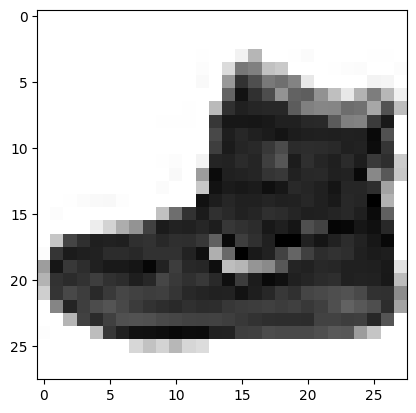

In [ ]:
# Veamos el elemento 0 y pintémoslo con matplotlib
digit = train_images[0]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [ ]:
print(train_labels.shape) #VECTOR DE 60000 ETIQUETAS, UNA PARA CADA IMAGEN DE TRAIN.

(60000,)


In [ ]:
# La imagen anterior corresponde con la clase 9. Hasta se puede intuir....
print(train_labels[0])
print(class_names[train_labels[0]])

9
Ankle boot


Los **datos de prueba**:

In [ ]:
print(test_images.shape)#VECTOR DE 10000 IMÁGENES, CADA UNA DE TAMAÑO 28x28

(10000, 28, 28)


In [ ]:
# Vemos la matriz de la imagen número 1 (28x28)
np.set_printoptions(precision=2, suppress=True, linewidth=145)
print(np.matrix(test_images[1]))

[[  0   0   0   0   0   0   0   0   0   0  13  67   0   0   0   0  50  38   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   8 120 209 226 247 237 255 255 255 247 238 235 172  72   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 137 239 252 243 234 229 238 244 246 240 230 232 239 248 251 194   0   0   0   0   0   0]
 [  0   0   0   0   0 102 255 231 228 227 228 233 230 230 229 228 232 232 231 227 224 252 179   0   0   0   0   0]
 [  0   0   0   0   0 233 241 229 231 255 255 238 231 227 238 246 228 230 227 234 235 229 241  20   0   0   0   0]
 [  0   0   0   0   0 248 241 231 255 149  47 252 228 255 242 216 238 232 255 228 220 234 250  54   0   0   0   0]
 [  0   0   0   0   0 255 240 232 255  15   0 255 237 191   0   0 214 255  13 123 255 234 252 114   0   0   0   0]
 [  0   0   0   0   6 255 238 239 255 177   0 255 255   0 130 116  47  65  43  37 255 236 249 162   0   0   0   0]
 [  0   0   0   0  32 255 236 245 255 204   0 255  84   0  37  28  31   0  25  1

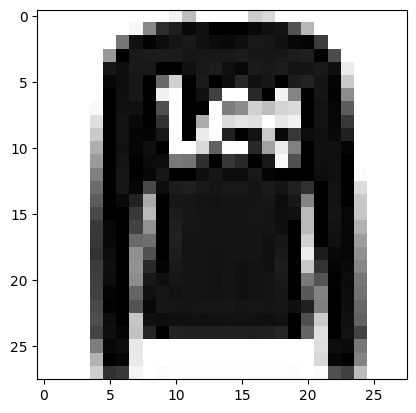

In [ ]:
# Veamos el elemento 1 de test y pintémoslo con matplotlib
digit = test_images[1]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [ ]:
# La imagen anterior corresponde con la clase 2. Hasta se puede intuir....
print(test_labels[1])
print(class_names[test_labels[1]])

2
Pullover


Por otro lado, se comprueba cuál es el balance de la base de datos tanto en el conjunto de entrenamiento como en el conjunto de test. Esto es, calcular el número de muestras de cada clase y observar si cada clase tiene el mismo número de muestras o si la base de datos está desequilibrada (alguna clase o algunas clases tienen muchas más muestras que otras):

In [ ]:
# Crea un contador para los índices
conteo_indices = Counter(train_labels)

# Imprime la cantidad de cada índice y el nombre de la clase correspondiente
print("TRAIN DATA:")
for indice, cantidad in conteo_indices.items():
    print(f'{class_names[indice]}: {cantidad}')

conteo_indices = Counter(test_labels)

# Imprime la cantidad de cada índice y el nombre de la clase correspondiente
print("\n\nTEST DATA:")
for indice, cantidad in conteo_indices.items():
    print(f'{class_names[indice]}: {cantidad}')

TRAIN DATA:
Ankle boot: 6000
T-shirt/top: 6000
Dress: 6000
Pullover: 6000
Sneaker: 6000
Sandal: 6000
Trouser: 6000
Shirt: 6000
Coat: 6000
Bag: 6000


TEST DATA:
Ankle boot: 1000
Pullover: 1000
Trouser: 1000
Shirt: 1000
Coat: 1000
Sandal: 1000
Sneaker: 1000
Dress: 1000
Bag: 1000
T-shirt/top: 1000


Se puede concluir que tanto los datos de entrenamiento como los de test estan igualmente repartidos entre las clases en cuestión. Esto va a ser beneficioso a la hora de entrenar y validar las redes neuronales artificiales que se desarrollen debido a que, con una base de datos desequilibrada se le podría estar alimentando a la red lo que se denomina una base de datos con sesgo. No se quiere operar con una base de datos con sesgo porque, así la red neuronal va a estar sesgada y pueden acabar ocurriendo eventos como el explicado en el siguiente artículo:

https://www.bbc.com/mundo/noticias-45823470


## Normalización

Se normalizan las imágenes a un rango de números del 0 al 1 para acelerar la convergencia de los modelos al entrenarse:

In [ ]:
# Normalizar los valores de píxeles al rango [0, 1] usando NumPy
train_images = np.divide(train_images, 255)
test_images = np.divide(test_images, 255)

## One-hot encoding

Se transforman las etiquetas al formato 'one-hot encoding' debido a que es necesario para que nuestros modelos puedan comparar sus salidas con las salidas esperadas, las cuales dichas etiquetas. 'One-hot encoding' consiste en convertir variables categóricas en vectores binarios de valores 0 y 1, donde cada valor en el vector corresponde a una categoría distinta. El término "one-hot" se refiere a que solo un valor en cada vector será "encendido" (1) mientras que los demás serán "apagados" (0).

In [ ]:
# Convertir las etiquetas a codificación one-hot
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

In [ ]:
# Verificar las etiquetas después de la codificación one-hot
print("Ejemplo de etiqueta antes de codificación one-hot:", test_labels[20])
print("Ejemplo de etiqueta después de codificación one-hot:", test_labels_categorical[20])

Ejemplo de etiqueta antes de codificación one-hot: 2
Ejemplo de etiqueta después de codificación one-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Con esto se termina el pre-procesamiento de datos.

## Utilización de Flatten

A continuación, se analiza el método keras.layers.Flatten() y su posible uso a lo largo de esta práctica.

La función keras.layers.Flatten() es un método de Keras que se trata de una capa que se le añade a la red neuronal, la cual aplana datos multidimensionales en una única dimensión. En el contexto de procesamiento de imágenes, esta capa se usa comúnmente para convertir una matriz bidimensional (como una imagen) en un vector unidimensional.

Cuando se aplica Flatten a una entrada, toma todos los elementos de la entrada y los coloca uno tras otro en un vector. Esto es útil cuando se trabaja con redes neuronales, ya que muchas capas densas (fully connected) requieren entradas unidimensionales.

Esta función se puede añadir sin problema a cualquier red que se quiera entrenar de forma automática, es decir, que la propia red se encargue del procesado de datos que después alimente al resto de las capas.

Vease el efecto que tiene una capa Flatten:

In [ ]:
# Verificar las formas resultantes
print("Shape de train_images ANTES:", train_images.shape)
print("Shape de test_images ANTES:", test_images.shape)
print()

# Aplanar las imágenes usando Flatten
flatten_layer = Flatten()
prueba_train_images = flatten_layer(train_images)
prueba_test_images = flatten_layer(test_images)

# Verificar las formas resultantes
print("Shape de train_images DESPUES:", prueba_train_images.shape)
print("Shape de test_images DESPUES:", prueba_test_images.shape)

Shape de train_images ANTES: (60000, 28, 28)
Shape de test_images ANTES: (10000, 28, 28)

Shape de train_images DESPUES: (60000, 784)
Shape de test_images DESPUES: (10000, 784)


Se puede observar que las variables de train y test images han pasado de tener 3 dimensiones a 2. Este método es muy conveniente (ya que con él, ya no hay que molestarse en transformar los datos a mano antes de introducirselo a un modelo) y se va a utilizar a lo largo de esta práctica.

# Apartado 1: Configuación modelos

En este apartado se debe configurar y entrenar los siguientes modelos de red de neuronas, todos con función de pérdida ‘categorical_crossentropy’, métrica de precisión y 5 épocas, analizando y reflexionando sobre los resultados.

Los modelos en cuestión son:

| CASO | #Neuronas_capa_1 | Función de activación | Optimizador |
|------|------------------|-----------------------|-------------|
| 1    | 10               | relu                  | sgd         |
| 2    | 10               | relu                  | rmsprop     |
| 3    | 10               | sigmoid               | sgd         |
| 4    | 10               | sigmoid               | rmsprop     |
| 5    | 512              | relu                  | sgd         |
| 6    | 512              | relu                  | rmsprop     |
| 7    | 512              | sigmoid               | sgd         |
| 8    | 512              | sigmoid               | rmsprop     |


Para ello, se ha creado un bucle en el cuál se crean, entrenan y validan estos 8 modelos en cuestión. Además, estos 8 modelos entrenados se guardan en la variable 'modelos', haciendo que de esta manera no sea necesario volver a crearlos y entrenarlos más tarde cuando sea necesario utilizar alguno de ellos.

También, se guarda en la variable 'rendimiento' el progreso (en cuanto a la pérdida y la precisión) que ha tenido cada modelo durante su entrenamiento en sus distintas épocas. Guardar el rendimiento es útil debido a que gracias a esos datos (valores de pérdida y precisión en cada época de entrenamiento) es posible hacer una gráfica en la que se observe la curva de aprendizaje en dos distintas gráficas, una para 'loss' (función de pérdida) y otra para 'accuracy' (tasa de acierto).

Además, en esas mismas gráficas se puede dibujar la precisión y la pérdida, de tal manera que se pueda ver si el modelo que se ha entrenado sufre 'overfitting', es decir, si el aprendizaje acaba con cierta precisión y al evaluarlo, la precisión es notablemente peor, esto es una señal de sobreentrenamiento.

Para ello, en primer lugar se ha creado una variable denominada 'casos' en la que en manera de diccionarios guarda los 8 casos distintos:

In [ ]:
casos = {
    1: {'Neuronas_capa_1': 10, 'Función de activación': 'relu', 'Optimizador': 'sgd'},
    2: {'Neuronas_capa_1': 10, 'Función de activación': 'relu', 'Optimizador': 'rmsprop'},
    3: {'Neuronas_capa_1': 10, 'Función de activación': 'sigmoid', 'Optimizador': 'sgd'},
    4: {'Neuronas_capa_1': 10, 'Función de activación': 'sigmoid', 'Optimizador': 'rmsprop'},
    5: {'Neuronas_capa_1': 512, 'Función de activación': 'relu', 'Optimizador': 'sgd'},
    6: {'Neuronas_capa_1': 512, 'Función de activación': 'relu', 'Optimizador': 'rmsprop'},
    7: {'Neuronas_capa_1': 512, 'Función de activación': 'sigmoid', 'Optimizador': 'sgd'},
    8: {'Neuronas_capa_1': 512, 'Función de activación': 'sigmoid', 'Optimizador': 'rmsprop'}
}

Y así, se configuran los 8 modelos en la siguiente celda de código:



CASO  1

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: sgd

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 1.4214 - accuracy: 0.5521
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.8146 - accuracy: 0.7282
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.6877 - accuracy: 0.7625
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.6282 - accuracy: 0.7831
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5912 - accuracy: 0.7969

 EVALUAR MODELO:
313/313 [==============================] - 1s 2ms/step - loss: 0.5993 - accuracy: 0.7901

 test_loss: 0.5992761254310608
 test_acc: 0.7900999784469604

 RENDIMIENTO ENTRENAMIENTO:


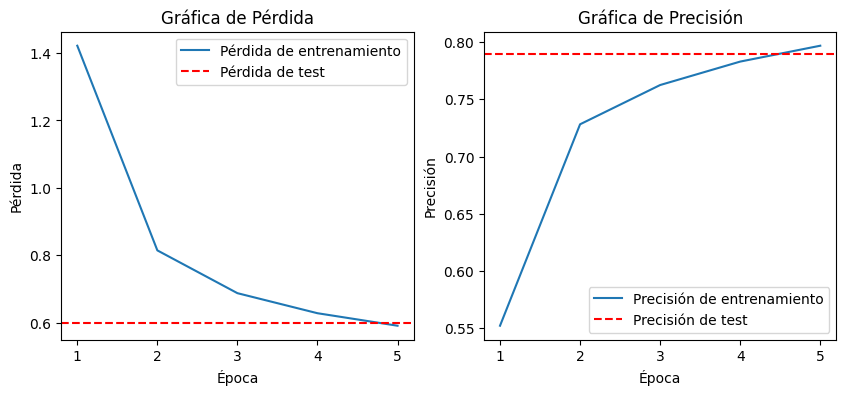



CASO  2

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: rmsprop

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.8395 - accuracy: 0.7162
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5178 - accuracy: 0.8231
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4713 - accuracy: 0.8374
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.4490 - accuracy: 0.8445
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.4346 - accuracy: 0.8498

 EVALUAR MODELO:
313/313 [==============================] - 1s 2ms/step - loss: 0.4828 - accuracy: 0.8314

 test_loss: 0.48281747102737427
 test_acc: 0.8313999772071838

 RENDIMIENTO ENTRENAMIENTO:


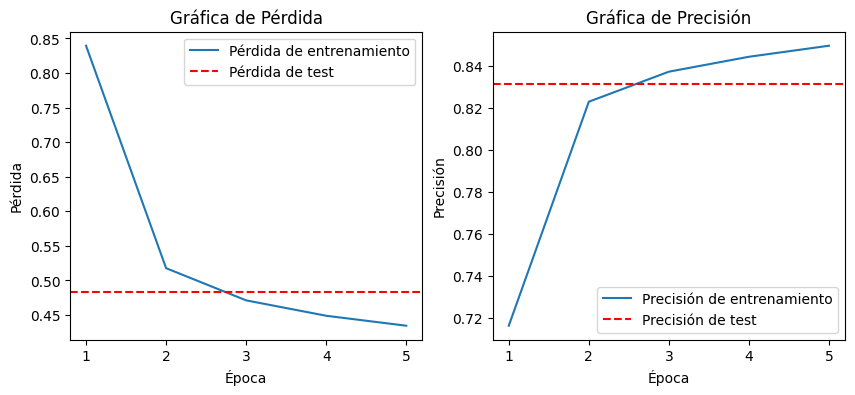



CASO  3

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: sgd

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 2.1206 - accuracy: 0.3292
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 1.8131 - accuracy: 0.4963
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 1.5856 - accuracy: 0.5506
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 1.4229 - accuracy: 0.5882
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 1.3050 - accuracy: 0.6063

 EVALUAR MODELO:
313/313 [==============================] - 1s 3ms/step - loss: 1.2617 - accuracy: 0.6102

 test_loss: 1.2616816759109497
 test_acc: 0.6101999878883362

 RENDIMIENTO ENTRENAMIENTO:


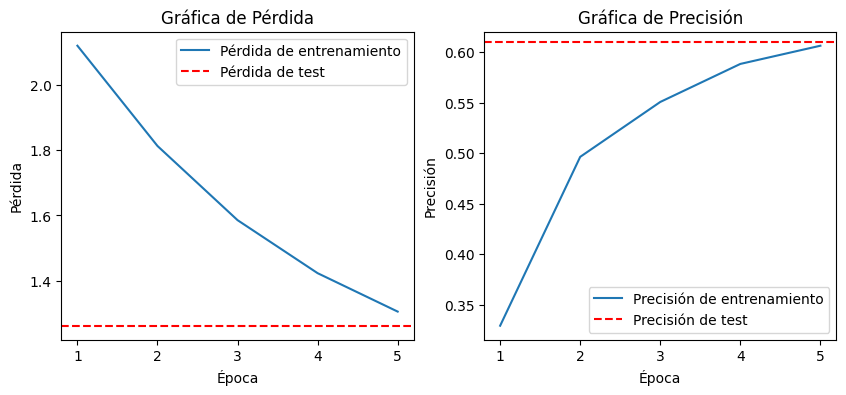



CASO  4

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: rmsprop

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 1.4211 - accuracy: 0.6464
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.8292 - accuracy: 0.7738
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.6316 - accuracy: 0.7995
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.5487 - accuracy: 0.8184
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5051 - accuracy: 0.8308

 EVALUAR MODELO:
313/313 [==============================] - 1s 2ms/step - loss: 0.5204 - accuracy: 0.8219

 test_loss: 0.5203648805618286
 test_acc: 0.8219000101089478

 RENDIMIENTO ENTRENAMIENTO:


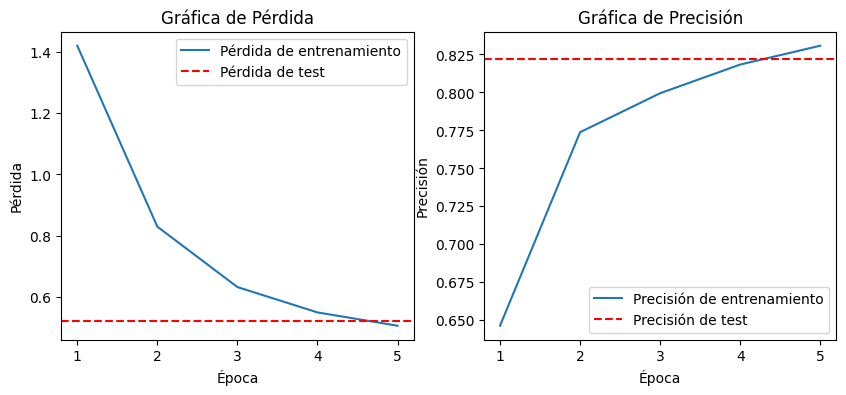



CASO  5

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: sgd

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 0.9984 - accuracy: 0.7057
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 0.6544 - accuracy: 0.7909
Epoch 3/5
469/469 [==============================] - 4s 10ms/step - loss: 0.5790 - accuracy: 0.8123
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.5387 - accuracy: 0.8228
Epoch 5/5
469/469 [==============================] - 6s 14ms/step - loss: 0.5121 - accuracy: 0.8299

 EVALUAR MODELO:
313/313 [==============================] - 2s 5ms/step - loss: 0.5284 - accuracy: 0.8197

 test_loss: 0.5284139513969421
 test_acc: 0.8197000026702881

 RENDIMIENTO ENTRENAMIENTO:


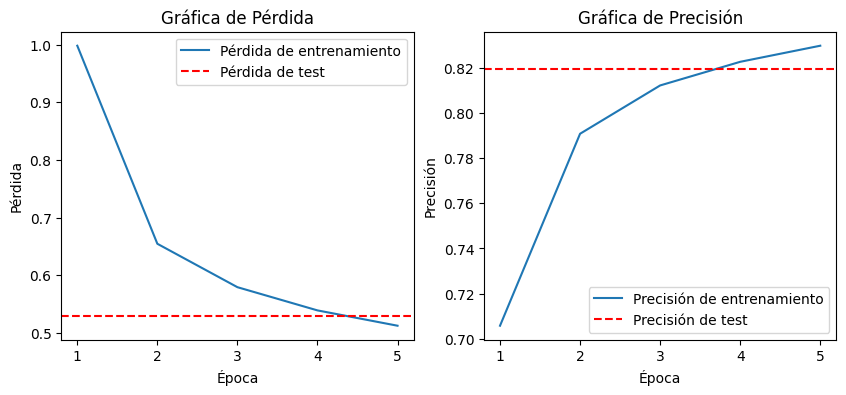



CASO  6

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: rmsprop

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 6s 11ms/step - loss: 0.5519 - accuracy: 0.8037
Epoch 2/5
469/469 [==============================] - 6s 13ms/step - loss: 0.3824 - accuracy: 0.8603
Epoch 3/5
469/469 [==============================] - 7s 15ms/step - loss: 0.3395 - accuracy: 0.8754
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.3136 - accuracy: 0.8838
Epoch 5/5
469/469 [==============================] - 6s 13ms/step - loss: 0.2945 - accuracy: 0.8921

 EVALUAR MODELO:
313/313 [==============================] - 1s 3ms/step - loss: 0.3544 - accuracy: 0.8742

 test_loss: 0.35439833998680115
 test_acc: 0.8741999864578247

 RENDIMIENTO ENTRENAMIENTO:


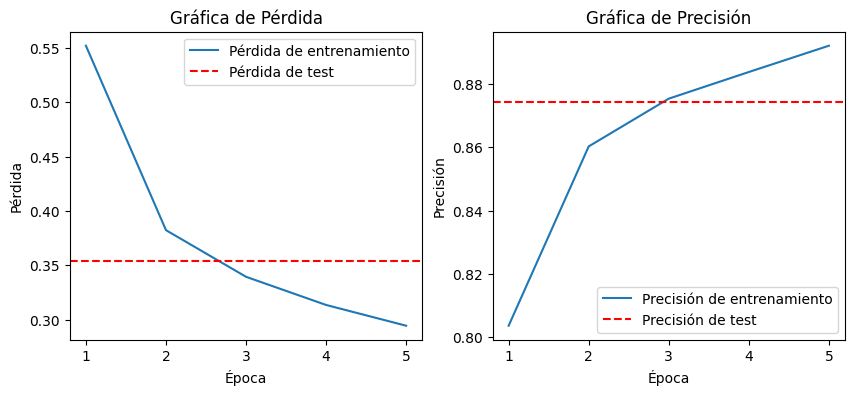



CASO  7

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: sigmoid
 - Optimizador: sgd

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 7s 14ms/step - loss: 1.7035 - accuracy: 0.5957
Epoch 2/5
469/469 [==============================] - 5s 11ms/step - loss: 1.1230 - accuracy: 0.7100
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.9209 - accuracy: 0.7284
Epoch 4/5
469/469 [==============================] - 5s 11ms/step - loss: 0.8210 - accuracy: 0.7416
Epoch 5/5
469/469 [==============================] - 7s 14ms/step - loss: 0.7609 - accuracy: 0.7509

 EVALUAR MODELO:
313/313 [==============================] - 3s 4ms/step - loss: 0.7514 - accuracy: 0.7482

 test_loss: 0.7514111995697021
 test_acc: 0.748199999332428

 RENDIMIENTO ENTRENAMIENTO:


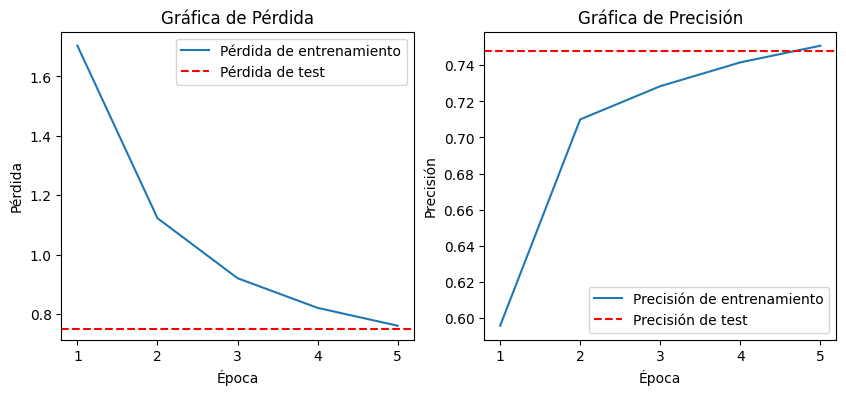



CASO  8

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: sigmoid
 - Optimizador: rmsprop

 ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 6s 12ms/step - loss: 0.6145 - accuracy: 0.7851
Epoch 2/5
469/469 [==============================] - 8s 17ms/step - loss: 0.4511 - accuracy: 0.8364
Epoch 3/5
469/469 [==============================] - 6s 12ms/step - loss: 0.4125 - accuracy: 0.8508
Epoch 4/5
469/469 [==============================] - 6s 12ms/step - loss: 0.3865 - accuracy: 0.8594
Epoch 5/5
469/469 [==============================] - 8s 17ms/step - loss: 0.3676 - accuracy: 0.8661

 EVALUAR MODELO:
313/313 [==============================] - 1s 4ms/step - loss: 0.4370 - accuracy: 0.8414

 test_loss: 0.43701034784317017
 test_acc: 0.8414000272750854

 RENDIMIENTO ENTRENAMIENTO:


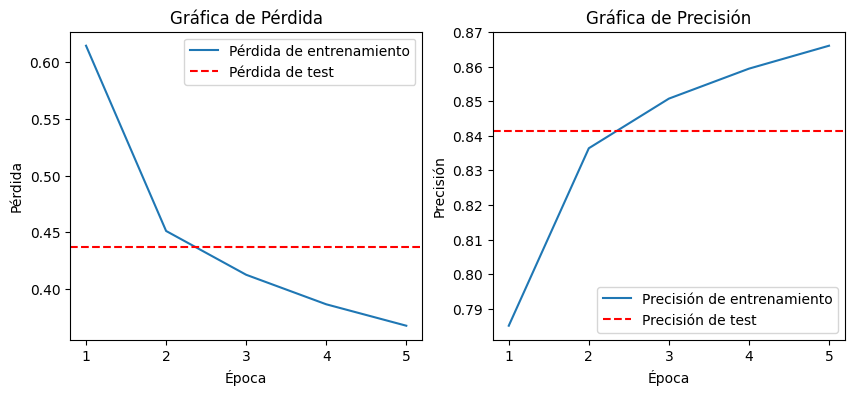

In [ ]:
modelos = [] # Guardará los modelos
rendimiento = []  # Guardará las variables history que tiene la info del renidmientode cada modelo

for i in range(1,9):
    network = models.Sequential()

    print("\n\n=======================================================================")
    print("CASO ", i)
    print("=======================================================================")

    # DATOS DEL CASO
    n_neuronas = casos[i]['Neuronas_capa_1']
    f_activacion = casos[i]['Función de activación']
    optimizador = casos[i]['Optimizador']

    print("\n Características del caso:")
    print(f" - Número de neuronas en la capa 1: {n_neuronas}")
    print(f" - Función de activación: {f_activacion}")
    print(f" - Optimizador: {optimizador}")

    # MODELO:
    network.add(Flatten(input_shape = (28, 28)))
    network.add(layers.Dense(n_neuronas, activation=f_activacion))
    network.add(layers.Dense(10, activation='softmax'))

    network.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n ENTRENAMIENTO:")
    history = network.fit(train_images, train_labels_categorical, epochs=5, batch_size=128)

    # Los valores de pérdida y precisión en cada época se guardan en el atributo history
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']

    print("\n EVALUAR MODELO:")
    test_loss, test_acc = network.evaluate(test_images, test_labels_categorical)
    print('\n test_loss:', test_loss)
    print(' test_acc:', test_acc)

    print('\n RENDIMIENTO ENTRENAMIENTO:')
    rendimiento_entrenamiento(train_loss,train_acc, test_loss, test_acc)

    # GUARDO EL MODELO Y SUS DATOS
    modelos.append(network)
    rendimiento.append(history)

Para analizar los resultados, se van a utilizar las gráficas de rendimiento de cada modelo. También, se va a realizar de manera general centrándose en las características comunes que tienen ciertos modelos en vez de ir uno a uno. Después de analizar las gráficas de cada uno de los modelos se han llegado a las siguientes conclusiones:

- El optimizador 'sgd' suele dar peores precisiones. Esto tiene sentido ya que 'sgd' se refiere al algoritmo de descenso del gradiente original. Desde entonces se han creado muchos algoritmos mejorando 'sgd'. Un ejemplo de estos es 'rmsprop', que como se puede observar tiene una tendencia a crear modelos más precisos y con menos error.

- Por otro lado, aunque ningún modelo tenga sobreentrenamiento notable, se puede concluir a partir de las gráficas que el optimizador 'rmsprop' causa más sobreentrenamiento que 'sgd'. Al contrario, en la mayoría de casos, 'sgd' produce modelos con muy poco sobrenetrenamiento.

- También, cabe destacar que los modelos con 512 neuronas en la segunda capa son notablemente mejores, en general, que los que tienen 10 (no hay ningún modelo con 512 que de 'accuracy' por debajo de 70 (en la última ejecución)). Esto tiene sentido ya que, como hemos visto en clase, modelos de redes neuronales más complejos suelen dar mejores resultados y son capaces de realizar tareas más complejas.

- Por último, también destacar que, en general, los modelos con la función de activacion 'relu' funcionan mejor dando mejores resultados que los que implementan la función 'sigmoid'.

# Apartado 2: Summary


En este apartado se debe explicar la salida de la llamada model.summary() de cada uno de los 8 casos. Para ello, se ha codificado un bucle 'for' en el que se muestra el método 'summary' para cada uno de los 8 casos:

In [ ]:
for i in range(1,9):
    network = modelos[i-1]

    print("\n\n=======================================================================")
    print("CASO ", i)
    print("=======================================================================")

    # DATOS DEL CASO
    n_neuronas = casos[i]['Neuronas_capa_1']
    f_activacion = casos[i]['Función de activación']
    optimizador = casos[i]['Optimizador']

    print("\nCaracterísticas del caso:")
    print(f" - Número de neuronas en la capa 1: {n_neuronas}")
    print(f" - Función de activación: {f_activacion}")
    print(f" - Optimizador: {optimizador}")

    print("\nSUMMARY")
    network.summary()



CASO  1

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: sgd

SUMMARY
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 10)                7850      
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


CASO  2

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: rmsprop

SUMMARY
Model: "sequential_16"
________________

Se puede observar que este método muestra la arquitectura que tiene cada uno de los 8 modelos configurados. Además, especifica la cantidad de parámetros entrenables que hay por cada capa, así como el número total de parámetros de la red y el tipo de salida de cada capa y de la red.

Cabe destacar cómo se calcula el números de parámetros total de una red neuronal. El número total de parámetros en una red neuronal se calcula sumando el número de parámetros en cada capa de la red. Los parámetros en una red neuronal generalmente se refieren a los pesos y sesgos/umbrales. Así:

\begin{equation}
Numtotal = Numcapa_1 + Numcapa_2 + ... + Numcapa_i + ... + Numcapa_n
\end{equation}

donde, por ser densa,

\begin{equation}
Numcapa_i = Numentradas_i \cdot Numneuronas_i + Numneuronas_i
\end{equation}

Por ejemplo, para el caso 8, sería de la siguiente manera:

\begin{equation}
Numtotal = 0 + (784\cdot512+512) + (512\cdot10+10) = 407050.
\end{equation}


Se puede deducir que con estos modelos, la tabla que dibuja este método 'summary' depende del número de neuronas que tenga la capa intermedia, y en este caso solo hay dos opciones: ó 10 ó 512. Así, solo tenemos dos tipos de 'summary': los cuatro primeros, que tienen 7960 parámetros entrenables; y los cuatro últimos, que tienen 407050 parámetros entrenables. Esto se puede observar en la siguiente tabla resumen:

| CASO  | Trainable Params | Neuronas en Capa 1 |
|-------|------------------|--------------------|
| 1     | 7,960            | 10                 |
| 2     | 7,960            | 10                 |
| 3     | 7,960            | 10                 |
| 4     | 7,960            | 10                 |
| 5     | 407,050          | 512                |
| 6     | 407,050          | 512                |
| 7     | 407,050          | 512                |
| 8     | 407,050          | 512                |

# Apartado 3: Casos 2 y 7


En este apartado se debe analizar e interpretar los resultados del caso 2 y el 7 frente a sus originales, si las épocas de entrenamiento de los modelos originales se multiplican por 5.

Por esto, se desarrolla el siguiente bucle 'for' que configura y guarda los modelos 2 y 7 con 25 épocas de entrenamiento (guarda también su rendimiento de entrenamiento):

In [ ]:
modelos_apartado_3 = []
rendimiento_apartado_3 = []

for i in [2,7]:
    network = models.Sequential()

    print("\n\n=======================================================================")
    print("CASO ", i," DEL APARTADO 3 (25 EPOCAS)")
    print("=======================================================================")

    # DATOS DEL CASO
    n_neuronas = casos[i]['Neuronas_capa_1']
    f_activacion = casos[i]['Función de activación']
    optimizador = casos[i]['Optimizador']

    print("\nCaracterísticas del caso:")
    print(f" - Número de neuronas en la capa 1: {n_neuronas}")
    print(f" - Función de activación: {f_activacion}")
    print(f" - Optimizador: {optimizador}")

    # MODELO:
    network.add(Flatten(input_shape = (28, 28)))
    network.add(layers.Dense(n_neuronas, activation=f_activacion))
    network.add(layers.Dense(10, activation='softmax'))

    print("\n SUMMARY")
    network.summary()

    network.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n ENTRENAMIENTO:")
    history = network.fit(train_images, train_labels_categorical, epochs=25, batch_size=128)

    # GUARDO EL MODELO
    modelos_apartado_3.append(network)
    rendimiento_apartado_3.append(history)



CASO  2  DEL APARTADO 3 (25 EPOCAS)

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: rmsprop

 SUMMARY
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 dense_46 (Dense)            (None, 10)                7850      
                                                                 
 dense_47 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________

 ENTRENAMIENTO:
Epoch 1/25
469/469 [==============================] - 3s 5ms/step - loss: 0.8829 - accuracy: 0.6950
Epoch 2/25
469/469 [=========

Una vez configurados los modelos, se comparan con sus originales con las siguientes gráficas. Se comienza con el caso 2:

CASO 2 ORIGINAL

 EVALUAR MODELO:
313/313 [==============================] - 1s 2ms/step - loss: 0.4828 - accuracy: 0.8314

 test_loss: 0.48281747102737427
 test_acc: 0.8313999772071838

 RENDIMIENTO ENTRENAMIENTO:


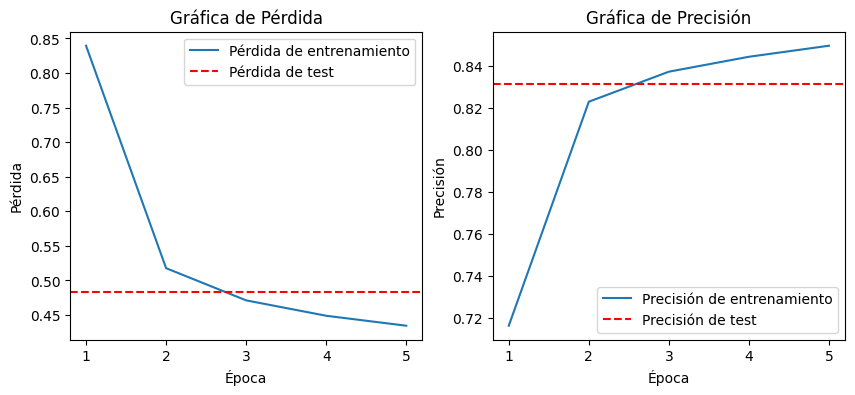



CASO 2 DEL APARTADO 3 (25 EPOCAS)

 EVALUAR MODELO:
313/313 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.8504

 test_loss: 0.43052300810813904
 test_acc: 0.8503999710083008

 RENDIMIENTO ENTRENAMIENTO:


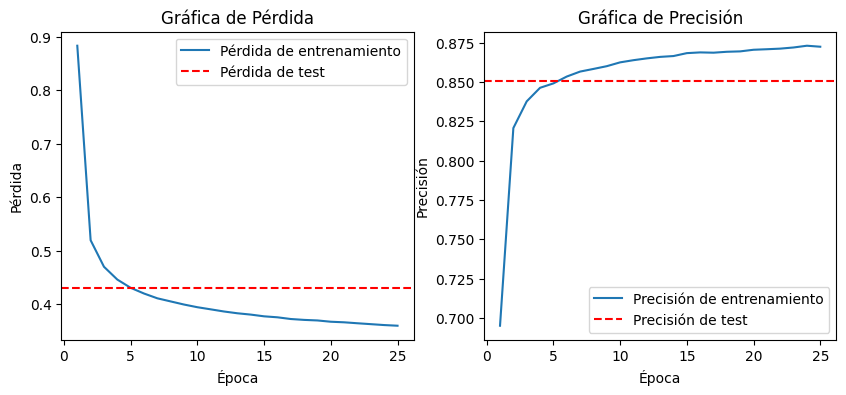

In [ ]:
# CASO 2 ORIGINAL:
print("=======================================================================")
print("CASO 2 ORIGINAL")
print("=======================================================================")
train_loss = rendimiento[1].history['loss']
train_acc = rendimiento[1].history['accuracy']

print("\n EVALUAR MODELO:")
test_loss, test_acc = modelos[1].evaluate(test_images, test_labels_categorical)
print('\n test_loss:', test_loss)
print(' test_acc:', test_acc)

print('\n RENDIMIENTO ENTRENAMIENTO:')
rendimiento_entrenamiento(train_loss,train_acc, test_loss, test_acc)

# CASO 2 - 25 épocas:
print("\n\n=======================================================================")
print("CASO 2 DEL APARTADO 3 (25 EPOCAS)")
print("=======================================================================")
train_loss = rendimiento_apartado_3[0].history['loss']
train_acc = rendimiento_apartado_3[0].history['accuracy']

print("\n EVALUAR MODELO:")
test_loss, test_acc = modelos_apartado_3[0].evaluate(test_images, test_labels_categorical)
print('\n test_loss:', test_loss)
print(' test_acc:', test_acc)

print('\n RENDIMIENTO ENTRENAMIENTO:')
rendimiento_entrenamiento(train_loss,train_acc, test_loss, test_acc)

Las conclusiones que se sacan a partir de estas gráficas son que, sí, al poner 25 épocas, se mejora tanto el error como la precisión. No obstante, la mejora es de 0.02 en precisión y 0.05 en error, lo cuál se podría decir que es bastante poco. Entonces surge la siguiente pregunta: ¿Merecen la pena las 25 épocas, con lo que conlleva (computacionalmente) para una mejora de 0.1 en precisión?

Quizás, habrá otros casos en los que un número alto de épocas de entrenamiento será beneficioso, pero se concluye que en este caso no merece la pena debido al insignificante cambio que aporta.

Por otro lado, también se compara el caso 7:

CASO 7 ORIGINAL

 EVALUAR MODELO:
313/313 [==============================] - 2s 5ms/step - loss: 0.7514 - accuracy: 0.7482

 test_loss: 0.7514111995697021
 test_acc: 0.748199999332428

 RENDIMIENTO ENTRENAMIENTO:


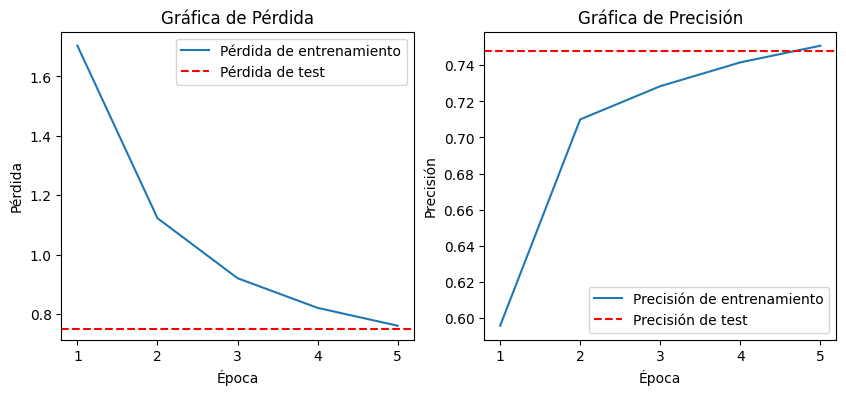



CASO 7 DEL APARTADO 3 (25 EPOCAS)

 EVALUAR MODELO:
313/313 [==============================] - 2s 5ms/step - loss: 0.5338 - accuracy: 0.8116

 test_loss: 0.5338282585144043
 test_acc: 0.8116000294685364

 RENDIMIENTO ENTRENAMIENTO:


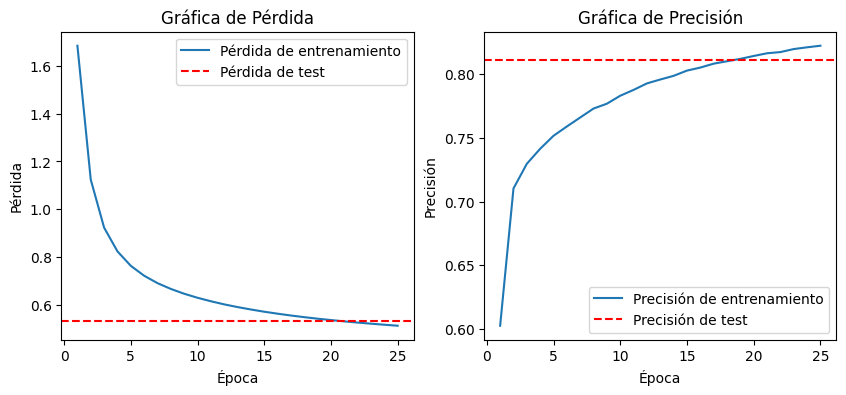

In [ ]:
# CASO 2 ORIGINAL:
print("=======================================================================")
print("CASO 7 ORIGINAL")
print("=======================================================================")
train_loss = rendimiento[6].history['loss']
train_acc = rendimiento[6].history['accuracy']

print("\n EVALUAR MODELO:")
test_loss, test_acc = modelos[6].evaluate(test_images, test_labels_categorical)
print('\n test_loss:', test_loss)
print(' test_acc:', test_acc)

print('\n RENDIMIENTO ENTRENAMIENTO:')
rendimiento_entrenamiento(train_loss,train_acc, test_loss, test_acc)

# CASO 2 - 25 épocas:
print("\n\n=======================================================================")
print("CASO 7 DEL APARTADO 3 (25 EPOCAS)")
print("=======================================================================")
train_loss = rendimiento_apartado_3[1].history['loss']
train_acc = rendimiento_apartado_3[1].history['accuracy']

print("\n EVALUAR MODELO:")
test_loss, test_acc = modelos_apartado_3[1].evaluate(test_images, test_labels_categorical)
print('\n test_loss:', test_loss)
print(' test_acc:', test_acc)

print('\n RENDIMIENTO ENTRENAMIENTO:')
rendimiento_entrenamiento(train_loss,train_acc, test_loss, test_acc)

Las conclusiones que se sacan a partir de estas gráficas son que, sí, al poner 25 épocas, se mejora tanto el error como la precisión y, al contrario que anteriormente con el caso 2, la mejora sí que es significante. En precisión se mejora un 0.07 y en pérdida un 0.22. Además, con las 25 épocas, tampoco hay un gran incremento en 'overfitting' (al contrario, es muy pequeño).

Entonces, respondiendo a la misma preguntada planteada con el caso 2, concluimos que en este caso sí que merece la pena el uso de 25 épocas de aprendizaje.

# Apartado 4: Evaluar modelos

En este apartado se debe evaluar cada uno de los 8 modelos comparando el rendimiento del modelo en el conjunto de datos de prueba. Para ello se va a crear una tabla resumen en la que se guarden el valor de pérdida y la precisión que nos ayude a comparar el rendimiento de cada uno de los modelos; y también se van a utilizar matrices de confusión.

Una matriz de confusión es una herramienta utilizada en el campo de la estadística y el aprendizaje automático para evaluar el rendimiento de un modelo de clasificación. Se utiliza para resumir el rendimiento del modelo al comparar las predicciones del modelo con los valores reales de un conjunto de datos. Tienen la siguiente forma:

|               | Predicción Positiva | Predicción Negativa |
| ------------- | ------------------- | ------------------- |
| Real Positiva | True Positive (TP)  | False Negative (FN) |
| Real Negativa | False Positive (FP) | True Negative (TN)  |

No obstante, en estos casos se obtienen matrices de confusión de tamaño 10x10 y los conceptos de 'true positives', 'true negatives', ..., se diluyen un poco y no aportan tanta información. Por esto, se utilizan las matrices de confusión, no para obtener estos datos mencionados sino para exponer las debilidades de los modelos, es decir, para ver que clases exactamente son las que cada uno de los modelos predicen mejor o peor.

Aquí, se hacen los cálculos necesarios para construir la tabla mencionada:

In [ ]:
# Crear un DataFrame vacío con nombres de columnas
col_names = ["Caso", "test_loss","test_acc","ACIERTOS","FALLOS"]
df = pd.DataFrame(columns=col_names)

for i in range(1,9):
    network = modelos[i-1]

    test_loss, test_acc = network.evaluate(test_images, test_labels_categorical)

    # VALORES DE LA TABLA
    aciertos = test_acc * 10000
    fallos = (1-test_acc) * 10000

    # Crear un diccionario con los valores
    data = {"Caso": i, "test_loss": test_loss, "test_acc": test_acc, "ACIERTOS": aciertos, "FALLOS": fallos}

    # Añadir los valores al DataFrame
    df = df.append(data, ignore_index=True)

 28/313 [=>............................] - ETA: 0s - loss: 0.4426 - accuracy: 0.8538

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


 32/313 [==>...........................] - ETA: 0s - loss: 1.2585 - accuracy: 0.6152

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


 25/313 [=>............................] - ETA: 0s - loss: 0.5078 - accuracy: 0.8438

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


 13/313 [>.............................] - ETA: 1s - loss: 0.4664 - accuracy: 0.8389

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


 19/313 [>.............................] - ETA: 0s - loss: 0.3129 - accuracy: 0.8832

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


 17/313 [>.............................] - ETA: 0s - loss: 0.7046 - accuracy: 0.7702

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


 34/313 [==>...........................] - ETA: 0s - loss: 0.4146 - accuracy: 0.8474

<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


313/313 [==============================] - 1s 3ms/step - loss: 0.4370 - accuracy: 0.8414


<ipython-input-102-086464bb6a71>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data, ignore_index=True)


In [ ]:
df.set_index('Caso', inplace=True)  # oEstablecer la columna 'Caso' como índice
print(tabulate(df, headers='keys', tablefmt='psql'))

+--------+-------------+------------+------------+----------+
|   Caso |   test_loss |   test_acc |   ACIERTOS |   FALLOS |
|--------+-------------+------------+------------+----------|
|      1 |    0.599276 |     0.7901 |       7901 |     2099 |
|      2 |    0.482817 |     0.8314 |       8314 |     1686 |
|      3 |    1.26168  |     0.6102 |       6102 |     3898 |
|      4 |    0.520365 |     0.8219 |       8219 |     1781 |
|      5 |    0.528414 |     0.8197 |       8197 |     1803 |
|      6 |    0.354398 |     0.8742 |       8742 |     1258 |
|      7 |    0.751411 |     0.7482 |       7482 |     2518 |
|      8 |    0.43701  |     0.8414 |       8414 |     1586 |
+--------+-------------+------------+------------+----------+


Gracias a esta tabla se puede observar como el modelo que tiene mejor precisión es el caso 6 (512, 'relu', 'rmsprop'), seguido del modelo 8 (512, sigmoid, rmsprop). Por otro lado, los dos peores modelos son el caso 3 (10, sigmoid, sgd) y el caso 7 (512, sigmoid, sgd). Es importante destacar como en este análisis se confirman las conclusiones que se sacaron de las gráficas en el apartado 1. Por ejemplo que 'sigmoid' es la f.activación que funciona peor o que los modelos con 'rmsprop' son mejores.

Por no alargar mucho más este apartado, se analizan con matrices de confusión el mejor y el peor caso. Se comienza con el mejor caso:

CASO 6

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: rmsprop
313/313 [==============================] - 1s 3ms/step
 PINTAMOS LA MATRIZ DE CONFUSION:


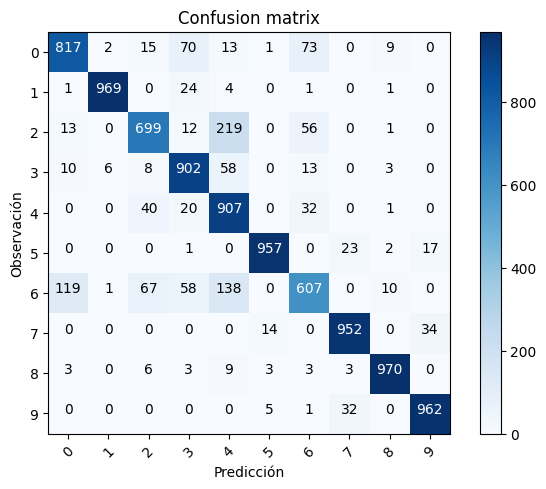

<Figure size 640x480 with 0 Axes>

In [ ]:
print("=======================================================================")
print("CASO 6")
print("=======================================================================")

# DATOS DEL CASO
n_neuronas = casos[6]['Neuronas_capa_1']
f_activacion = casos[6]['Función de activación']
optimizador = casos[6]['Optimizador']
print("\n Características del caso:")
print(f" - Número de neuronas en la capa 1: {n_neuronas}")
print(f" - Función de activación: {f_activacion}")
print(f" - Optimizador: {optimizador}")

# Predicción de valores desde el dataset de validación
Y_pred = modelos[5].predict(test_images)

# Convertir en predicciones de clases desde los vectores one-hot encoding
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = test_labels  # Aquí se ha cambiado 'np.argmax(test_labels)' por 'test_labels'

# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Dibujar la matriz de confusión
print(" PINTAMOS LA MATRIZ DE CONFUSION:")
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se podría resaltar del caso 6 que predice notablemente mal las clases 6 y 2.

Ahora, se grafica la matriz de confusión del peor caso:

CASO 3

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: sgd
313/313 [==============================] - 1s 2ms/step
 PINTAMOS LA MATRIZ DE CONFUSION:


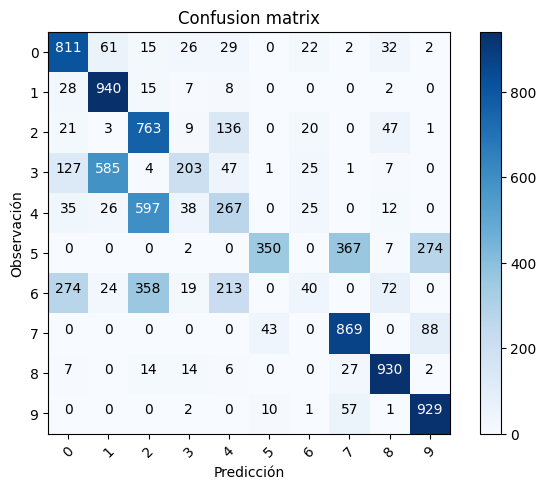

<Figure size 640x480 with 0 Axes>

In [ ]:
print("=======================================================================")
print("CASO 3")
print("=======================================================================")

# DATOS DEL CASO
n_neuronas = casos[3]['Neuronas_capa_1']
f_activacion = casos[3]['Función de activación']
optimizador = casos[3]['Optimizador']
print("\n Características del caso:")
print(f" - Número de neuronas en la capa 1: {n_neuronas}")
print(f" - Función de activación: {f_activacion}")
print(f" - Optimizador: {optimizador}")

# Predicción de valores desde el dataset de validación
Y_pred = modelos[2].predict(test_images)

# Convertir en predicciones de clases desde los vectores one-hot encoding
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = test_labels  # Aquí se ha cambiado 'np.argmax(test_labels)' por 'test_labels'

# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Dibujar la matriz de confusión
print(" PINTAMOS LA MATRIZ DE CONFUSION:")
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se podría resaltar del caso 3, para comenzar, que predice de manera completamente errónea la clase 6. También se puede observar que predice notablemente mal las clases 5, 4 y 3. También se equivoca bastante en la clase 7 y la 2.

Gracias a estas matrices de confusión se puede concluir que es necesario buscar maneras de mejorar todos los modelos, tanto el peor modelo (obviamente) como el mejor modelo. Una manera sería la búsqueda de la combinación óptima de hiperparámetros que resuelve mejor el problema en cuestión. Esto sería ir probando distintos valores para, por ejemplo, 'batch_size', que es el tamaño de los minilotes según los cuales las redes van actualizando los parámetros; o 'kernel_initializer', que es el hiperparámetro que define como se inicializan los pesos de los modelos.

# Apartado 5: Imagen 6

En este apartado se debe usar cada uno de los 8 modelos para hacer predicciones sobre la 6ª imagen de test (test_images[5]). Se mostrará como se comportan los diferentes modelos a la hora de predecir la imagen mostrada por el siguiente código.

Se predicen todas las imagenes del test por cada modelo y se guardan en una variable para poder compararlos en el siguiente apartados:

In [ ]:
predicciones = []
for i in range(1,9):
  prediction = modelos[i-1].predict(test_images)
  predicciones.append(prediction)

313/313 [==============================] - 1s 3ms/step


Se procede a estudiar y visualizar la imagen objeto de estudio:

In [ ]:
# Vemos la matriz de la imagen número 0 (28x28)
np.set_printoptions(precision=2, suppress=True, linewidth=145)
print(np.matrix(test_images[5]))

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.74 0.71 0.74 0.62 0.65 0.74 0.69 0.7  0.71 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.92 0.84 0.84 0.87 0.88 0.85 0.84 0.8  0.83 0.74 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.92 0.85 0.83 0.85 0.78 0.8  0.85 0.8  0.7  0.67 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.41 0.99 0.8  0.82 0.86 0.76 0.76 0.83 0.81 0.76 0.8  0.2  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.8  0.89 0.72 0.81 0.84 0.87 0.83 0.82 0.78 0.75 0.89 0.41 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.96 0.75 0.76 0.83 0.85 0.82 0.85 0.85 0.76 0.69 0.88 0.51 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.97 0.67 0.75 0.82 0.83 0.94 0.91 0.86 0.78 0.7  0.85 0.49 0.   0.   0.   0.   0.   0.   0.  ]

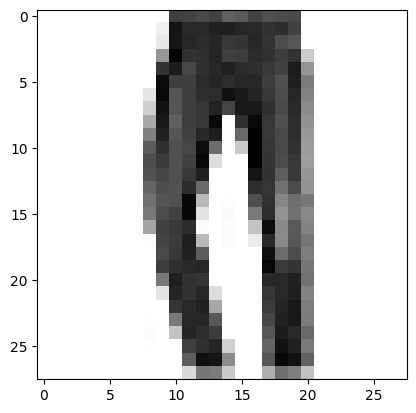

In [ ]:
# Veamos el elemento 0 y pintémoslo con matplotlib
digit = test_images[5]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

Se observa como la imagen es un vaquero (trouser) y efectivamente tiene la etiqueta correspondiente:

In [ ]:
# La imagen anterior corresponde con el número 1. Hasta se puede intuir....
print(test_labels[5])
print(class_names[test_labels[5]])

1
Trouser


En el siguiente fragmento, se proporciona el código que ilustra la respuesta de diversos modelos a una imagen en particular. Este código mostrará en la pantalla los resultados de las predicciones de cada modelo, representando en un gráfico la distribución de probabilidades asignadas por cada modelo a la imagen de interés.

 PREDICCION DEL MODELO  1

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: sgd

 PREDICCION PARA LA IMAGEN 6:

[0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]


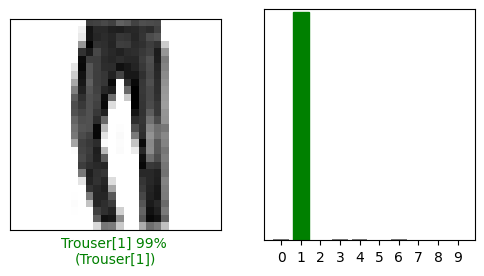




 PREDICCION DEL MODELO  2

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: rmsprop

 PREDICCION PARA LA IMAGEN 6:

[0.01 0.99 0.   0.   0.01 0.   0.   0.   0.   0.  ]


<Figure size 640x480 with 0 Axes>

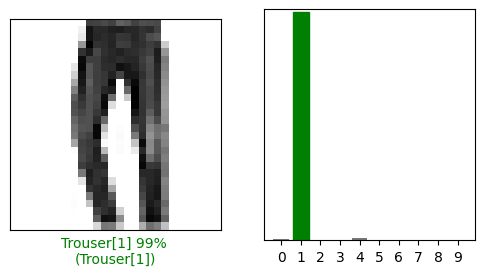




 PREDICCION DEL MODELO  3

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: sgd

 PREDICCION PARA LA IMAGEN 6:

[0.13 0.41 0.03 0.25 0.04 0.03 0.07 0.01 0.01 0.01]


<Figure size 640x480 with 0 Axes>

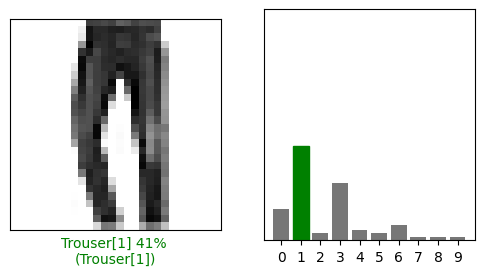




 PREDICCION DEL MODELO  4

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: rmsprop

 PREDICCION PARA LA IMAGEN 6:

[0.02 0.95 0.   0.02 0.   0.   0.   0.   0.   0.  ]


<Figure size 640x480 with 0 Axes>

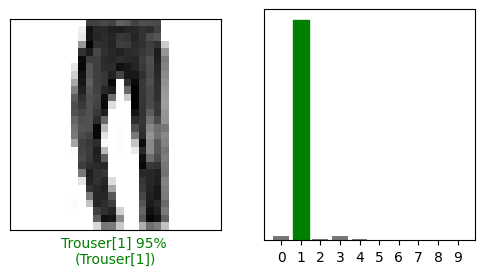




 PREDICCION DEL MODELO  5

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: sgd

 PREDICCION PARA LA IMAGEN 6:

[0.01 0.97 0.   0.   0.02 0.   0.   0.   0.   0.  ]


<Figure size 640x480 with 0 Axes>

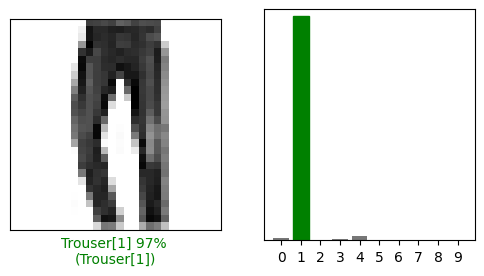




 PREDICCION DEL MODELO  6

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: rmsprop

 PREDICCION PARA LA IMAGEN 6:

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 640x480 with 0 Axes>

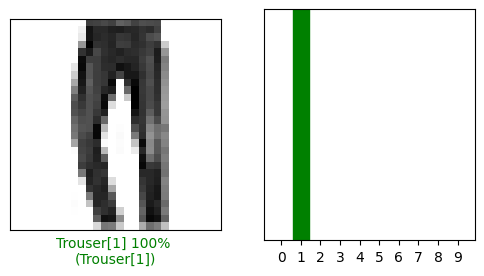




 PREDICCION DEL MODELO  7

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: sigmoid
 - Optimizador: sgd

 PREDICCION PARA LA IMAGEN 6:

[0.04 0.81 0.01 0.07 0.04 0.   0.02 0.   0.   0.  ]


<Figure size 640x480 with 0 Axes>

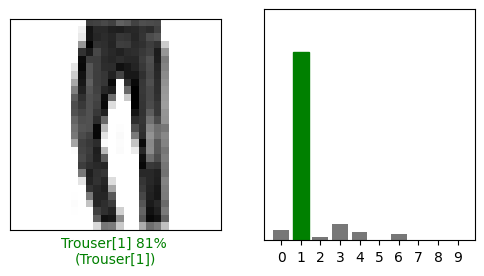




 PREDICCION DEL MODELO  8

 Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: sigmoid
 - Optimizador: rmsprop

 PREDICCION PARA LA IMAGEN 6:

[0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]


<Figure size 640x480 with 0 Axes>

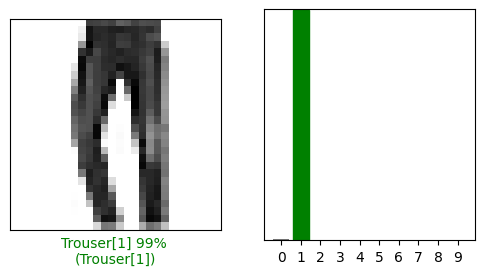

<Figure size 640x480 with 0 Axes>

In [ ]:
# Una vez que ya tenemos los modelos entrenados, procedemos comprobar como
# funcionan con nuestra imagen [5]:

for i in range(1,9):
  print("=======================================================================")
  print(" PREDICCION DEL MODELO ", i)
  print("=======================================================================")
  print("\n Características del caso:")
  print(f" - Número de neuronas en la capa 1: {casos[i]['Neuronas_capa_1']}")
  print(f" - Función de activación: {casos[i]['Función de activación']}")
  print(f" - Optimizador: {casos[i]['Optimizador']}")
  print("\n PREDICCION PARA LA IMAGEN 6:\n")
  print(predicciones[i-1][5])

  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(5, predicciones[i-1][5], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(5, predicciones[i-1][5],  test_labels)
  plt.show()
  plt.clf()
  print("\n\n")

Se observa como los modelos 2, 6 y 8 identifican esta imagen como un "vaquero" con un grado de certeza de casi 100% o igual. Aunque otros modelos también tienen altas tasas de acierto, es interesante destacar que para esta imagen, la categoría "vaquero" es la predicción más consistente. En resumen, ningún modelo ha cometido un error en la clasificación de esta imagen.

Asimismo, se aprecia que los modelos con mejores precisiones muestran la mayor seguridad en la clasificación de esta imagen como "vaquero" en comparación con los demás modelos. Estos modelos son: 2, 6, 8 y, además, el 4. Esto sugiere que, en este escenario, los modelos entrenados con el optimizador "RMSprop" son más efectivos, como se vió en el apartado 4 y 1.

Además, se pueden realizar observaciones coherentes con las conclusiones previamente establecidas. En particular, se nota que la función de activación que muestra el peor rendimiento es la sigmoid, como se ejemplifica en el caso 3, donde se utiliza:

- Cantidad de neuronas en la capa 1: 10
- Función de activación: sigmoid
- Optimizador: sgd

En este caso, se obtiene el modelo de menor calidad, con la cantidad más reducida de parámetros entrenables, el optimizador menos efectivo y la función de activación menos eficiente.

Es relevante destacar que el siguiente modelo con un rendimiento inferior es el modelo 7, que comparte la misma función de activación y el mismo optimizador. Sin embargo, la diferencia en la confianza con la que hace predicciones para esta imagen es significativamente mayor (de 0.41 a 0.81). Esto indica una marcada disparidad entre el peor modelo y el resto de modelos en términos de rendimiento.

# Apartado 6: Predicciones

En este apartado se debe utilizar para ver la predicción, igual que el gráfico anterior, de las 10 primeras imágenes del conjunto de test, para cada uno de los 8 casos. Se debe reflexionar y comentar las diferencias que observen.

En el siguiente fragmento, se proporciona el código que ilustra la respuesta de diversos modelos a las 10 primeras imágenes:

PREDICCIONES DEL MODELO  1

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: sgd

Prenda  0


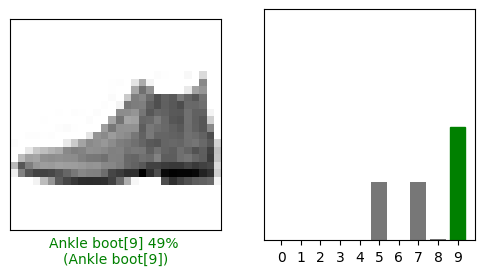


Prenda  1


<Figure size 640x480 with 0 Axes>

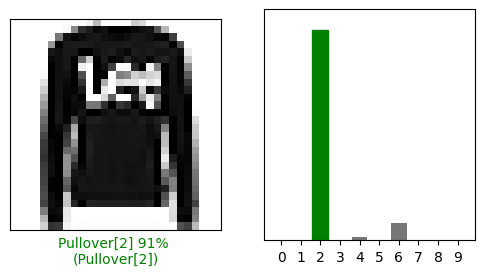


Prenda  2


<Figure size 640x480 with 0 Axes>

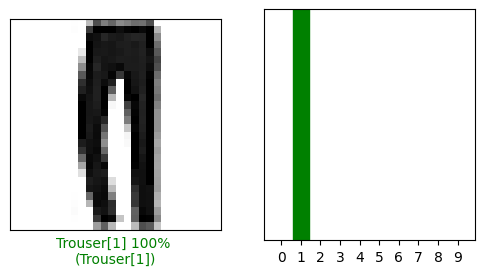


Prenda  3


<Figure size 640x480 with 0 Axes>

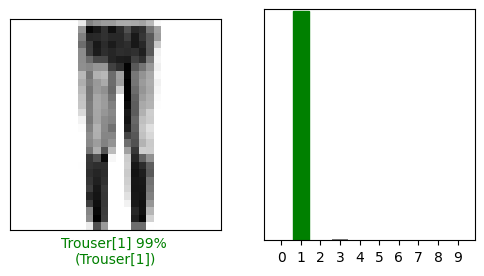


Prenda  4


<Figure size 640x480 with 0 Axes>

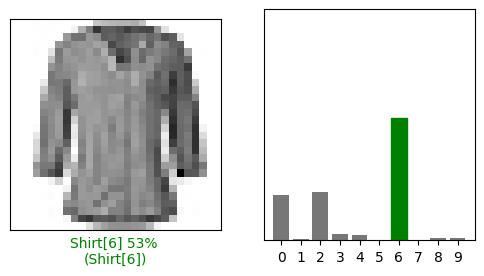


Prenda  5


<Figure size 640x480 with 0 Axes>

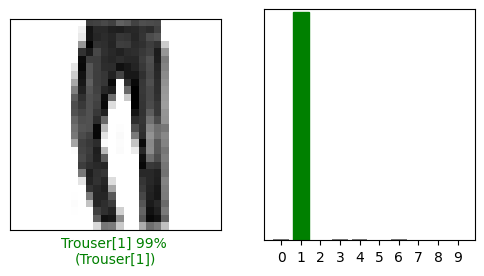


Prenda  6


<Figure size 640x480 with 0 Axes>

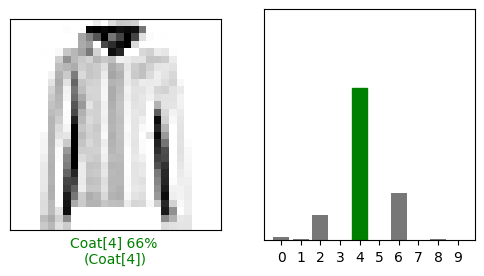


Prenda  7


<Figure size 640x480 with 0 Axes>

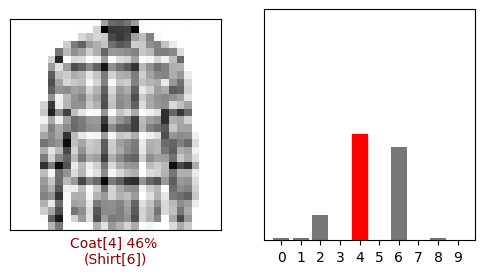


Prenda  8


<Figure size 640x480 with 0 Axes>

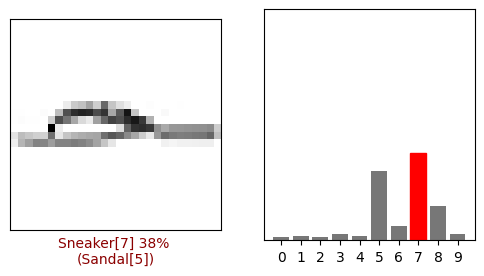


Prenda  9


<Figure size 640x480 with 0 Axes>

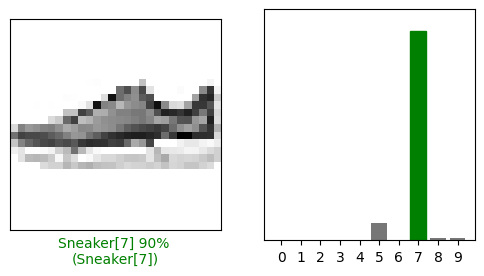

PREDICCIONES DEL MODELO  2

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: relu
 - Optimizador: rmsprop

Prenda  0


<Figure size 640x480 with 0 Axes>

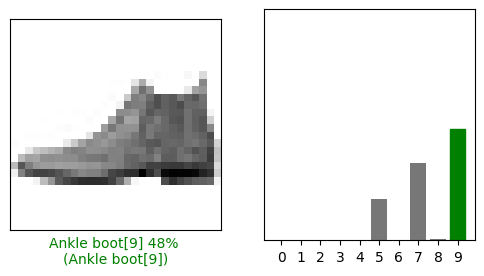


Prenda  1


<Figure size 640x480 with 0 Axes>

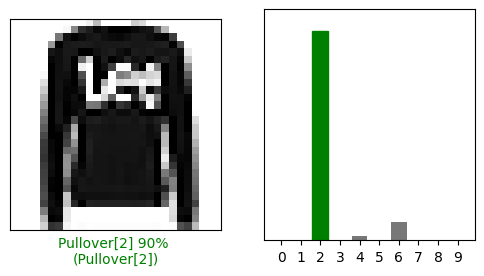


Prenda  2


<Figure size 640x480 with 0 Axes>

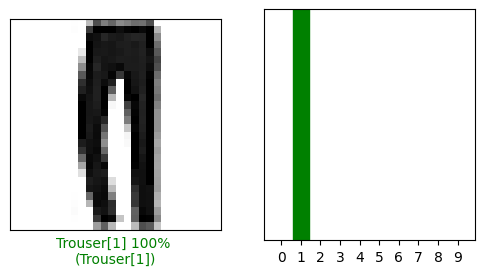


Prenda  3


<Figure size 640x480 with 0 Axes>

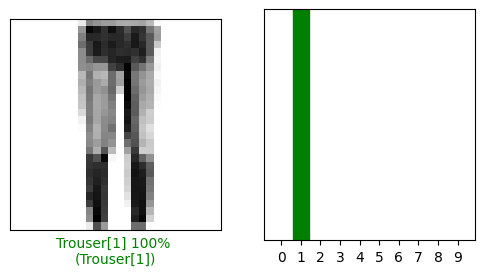


Prenda  4


<Figure size 640x480 with 0 Axes>

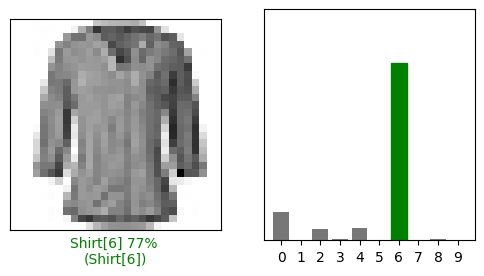


Prenda  5


<Figure size 640x480 with 0 Axes>

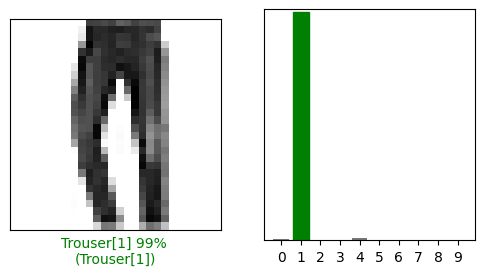


Prenda  6


<Figure size 640x480 with 0 Axes>

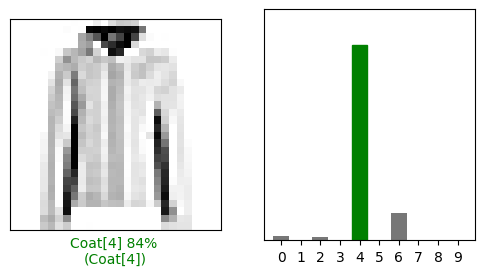


Prenda  7


<Figure size 640x480 with 0 Axes>

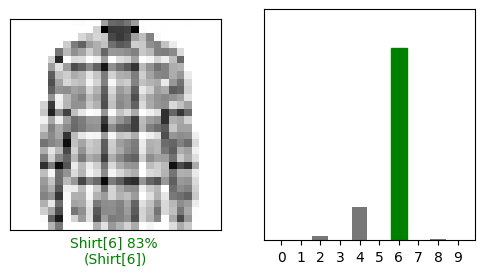


Prenda  8


<Figure size 640x480 with 0 Axes>

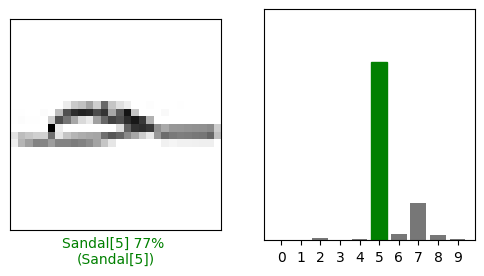


Prenda  9


<Figure size 640x480 with 0 Axes>

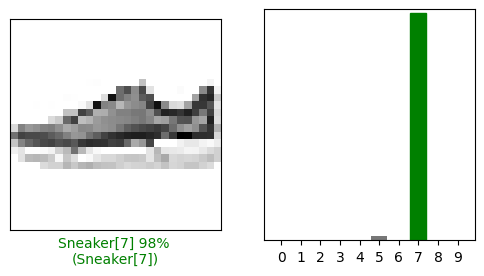

PREDICCIONES DEL MODELO  3

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: sgd

Prenda  0


<Figure size 640x480 with 0 Axes>

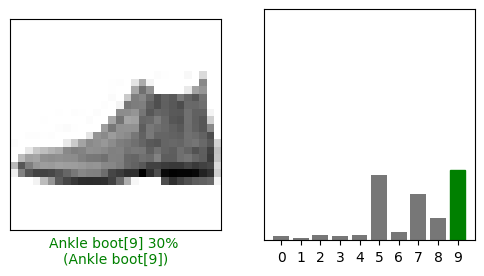


Prenda  1


<Figure size 640x480 with 0 Axes>

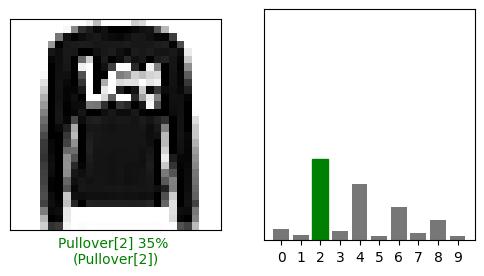


Prenda  2


<Figure size 640x480 with 0 Axes>

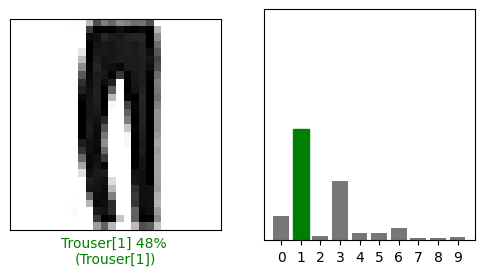


Prenda  3


<Figure size 640x480 with 0 Axes>

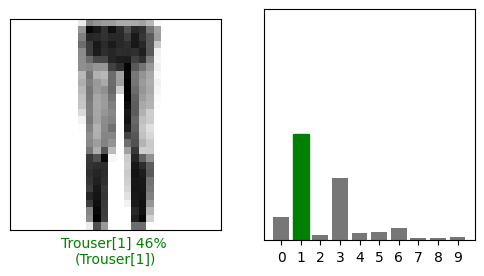


Prenda  4


<Figure size 640x480 with 0 Axes>

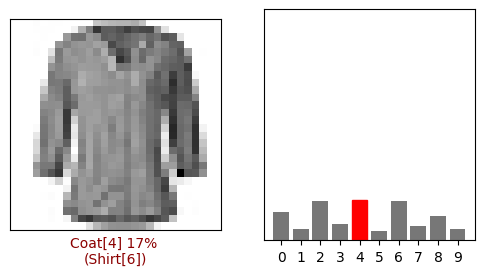


Prenda  5


<Figure size 640x480 with 0 Axes>

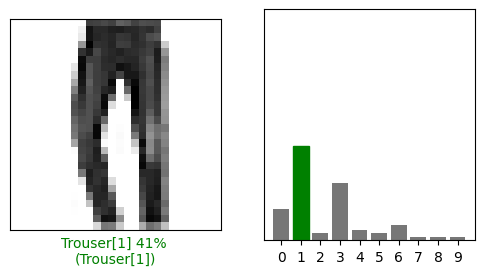


Prenda  6


<Figure size 640x480 with 0 Axes>

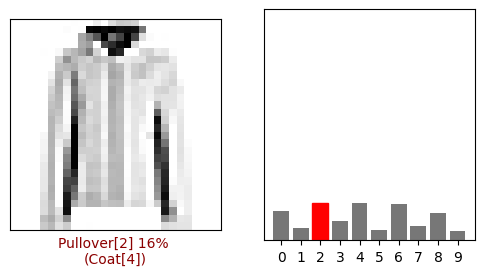


Prenda  7


<Figure size 640x480 with 0 Axes>

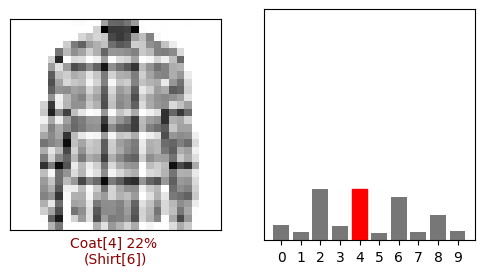


Prenda  8


<Figure size 640x480 with 0 Axes>

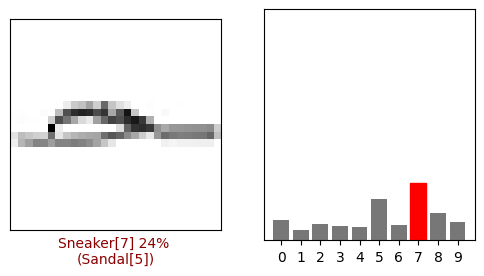


Prenda  9


<Figure size 640x480 with 0 Axes>

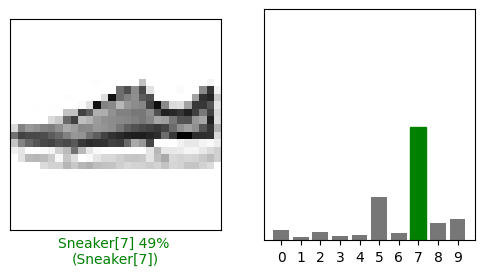

PREDICCIONES DEL MODELO  4

Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: rmsprop

Prenda  0


<Figure size 640x480 with 0 Axes>

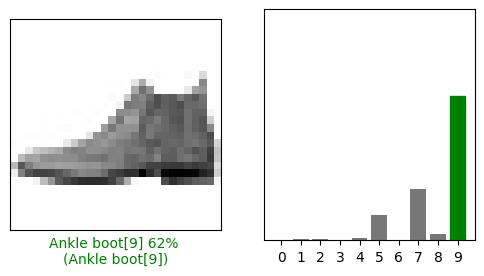


Prenda  1


<Figure size 640x480 with 0 Axes>

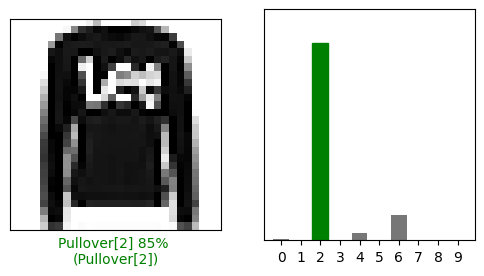


Prenda  2


<Figure size 640x480 with 0 Axes>

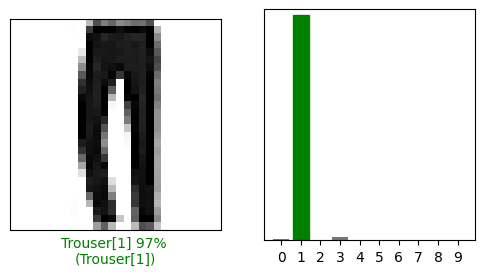


Prenda  3


<Figure size 640x480 with 0 Axes>

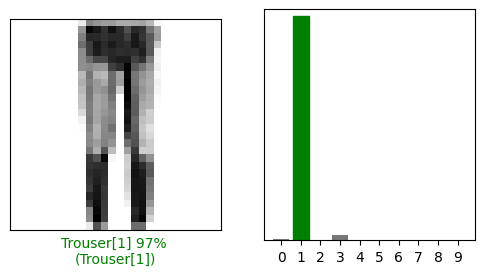


Prenda  4


<Figure size 640x480 with 0 Axes>

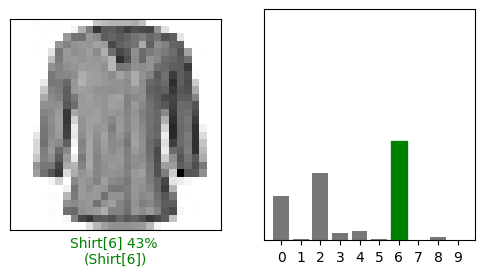


Prenda  5


<Figure size 640x480 with 0 Axes>

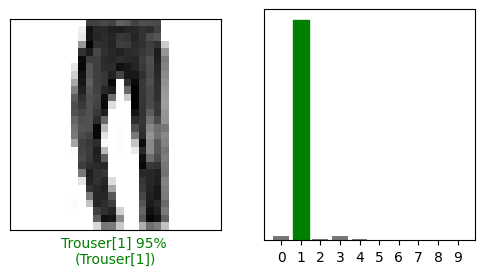


Prenda  6


<Figure size 640x480 with 0 Axes>

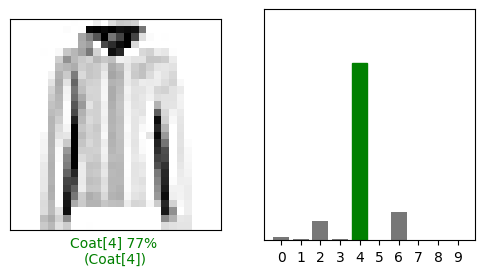


Prenda  7


<Figure size 640x480 with 0 Axes>

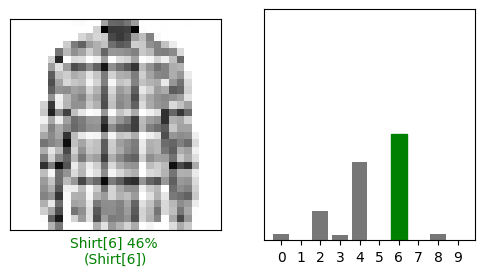


Prenda  8


<Figure size 640x480 with 0 Axes>

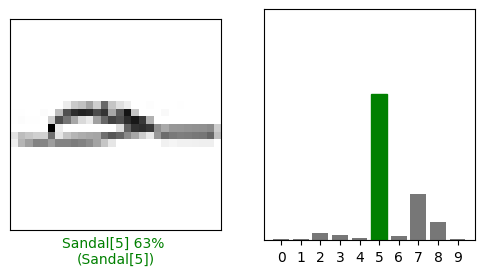


Prenda  9


<Figure size 640x480 with 0 Axes>

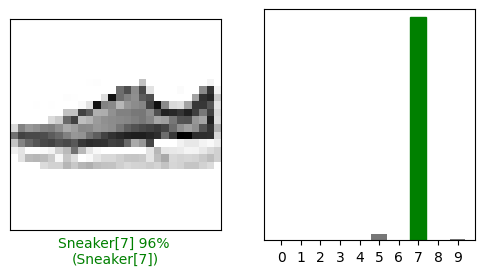

PREDICCIONES DEL MODELO  5

Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: sgd

Prenda  0


<Figure size 640x480 with 0 Axes>

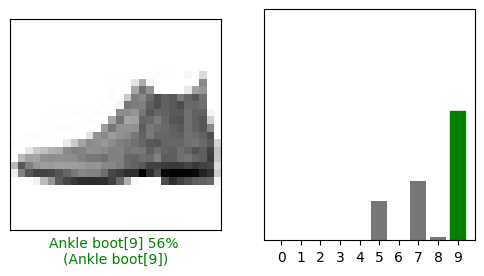


Prenda  1


<Figure size 640x480 with 0 Axes>

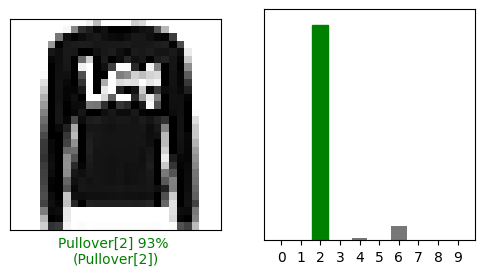


Prenda  2


<Figure size 640x480 with 0 Axes>

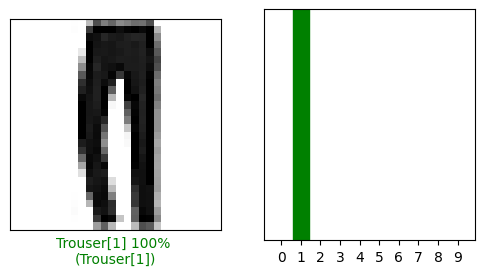


Prenda  3


<Figure size 640x480 with 0 Axes>

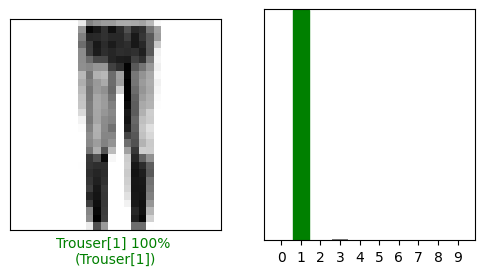


Prenda  4


<Figure size 640x480 with 0 Axes>

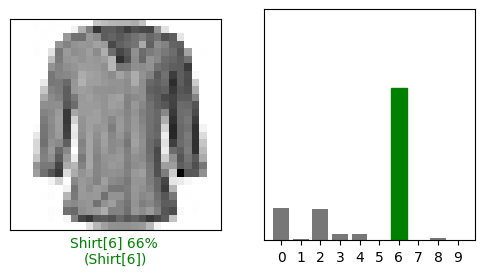


Prenda  5


<Figure size 640x480 with 0 Axes>

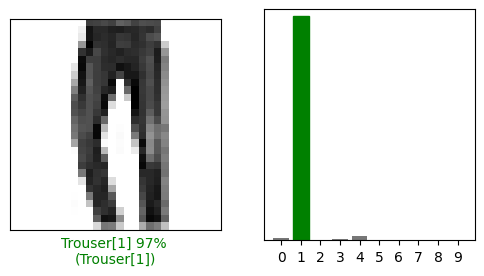


Prenda  6


<Figure size 640x480 with 0 Axes>

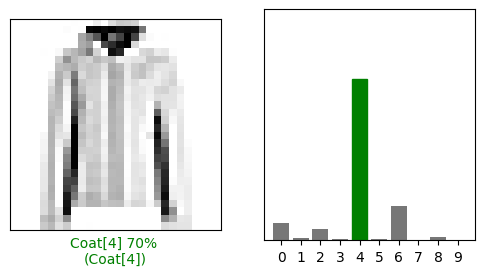


Prenda  7


<Figure size 640x480 with 0 Axes>

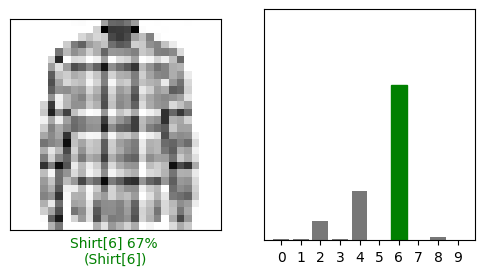


Prenda  8


<Figure size 640x480 with 0 Axes>

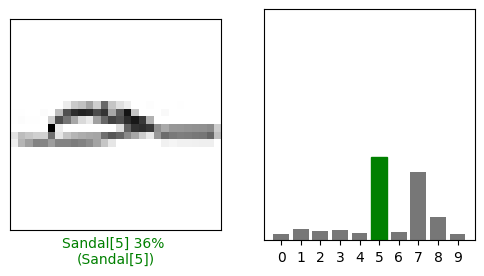


Prenda  9


<Figure size 640x480 with 0 Axes>

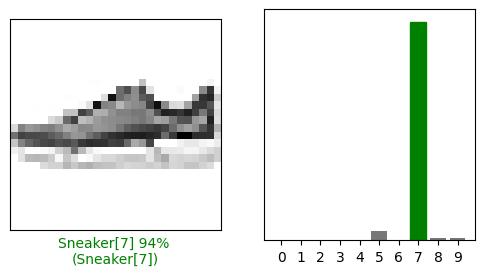

PREDICCIONES DEL MODELO  6

Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: relu
 - Optimizador: rmsprop

Prenda  0


<Figure size 640x480 with 0 Axes>

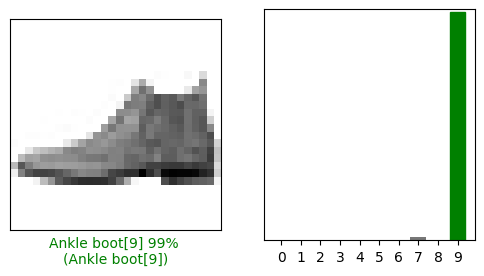


Prenda  1


<Figure size 640x480 with 0 Axes>

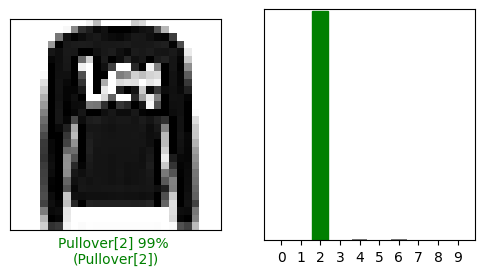


Prenda  2


<Figure size 640x480 with 0 Axes>

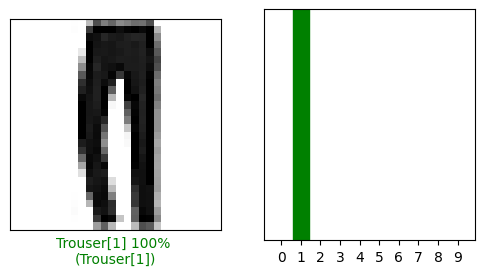


Prenda  3


<Figure size 640x480 with 0 Axes>

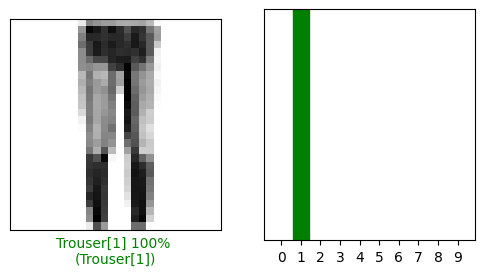


Prenda  4


<Figure size 640x480 with 0 Axes>

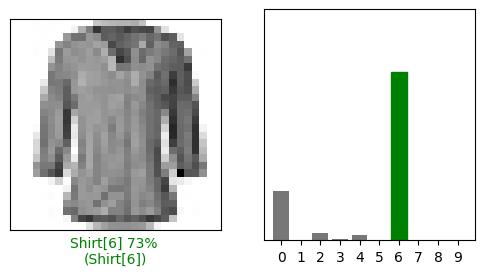


Prenda  5


<Figure size 640x480 with 0 Axes>

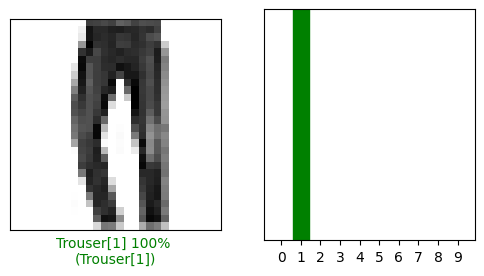


Prenda  6


<Figure size 640x480 with 0 Axes>

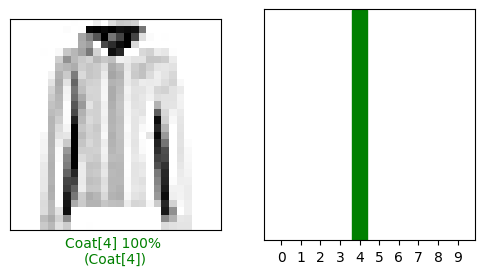


Prenda  7


<Figure size 640x480 with 0 Axes>

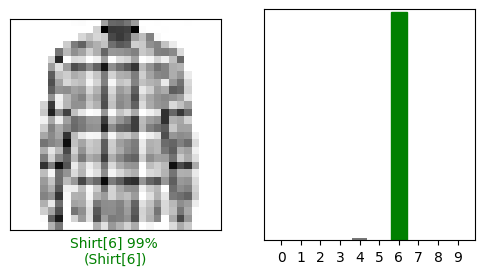


Prenda  8


<Figure size 640x480 with 0 Axes>

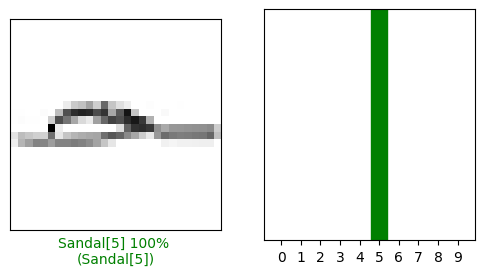


Prenda  9


<Figure size 640x480 with 0 Axes>

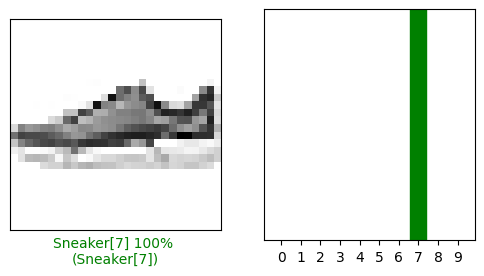

PREDICCIONES DEL MODELO  7

Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: sigmoid
 - Optimizador: sgd

Prenda  0


<Figure size 640x480 with 0 Axes>

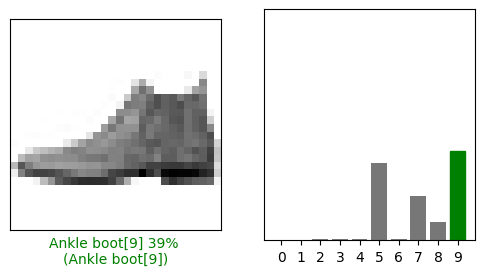


Prenda  1


<Figure size 640x480 with 0 Axes>

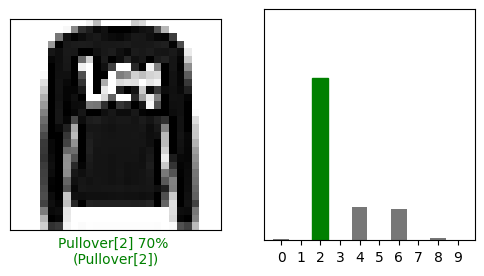


Prenda  2


<Figure size 640x480 with 0 Axes>

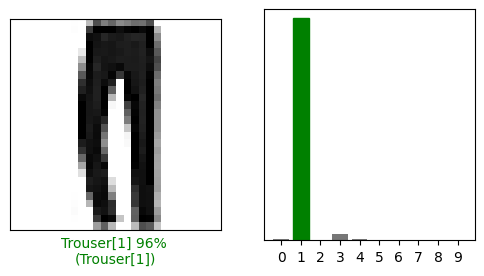


Prenda  3


<Figure size 640x480 with 0 Axes>

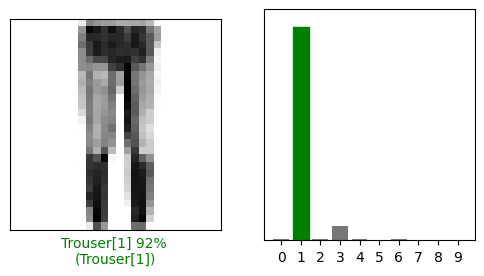


Prenda  4


<Figure size 640x480 with 0 Axes>

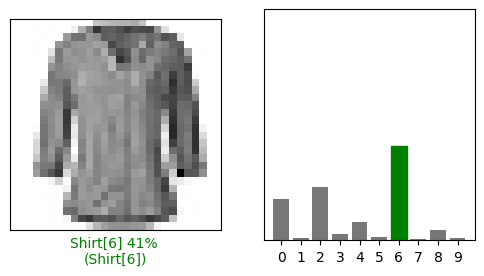


Prenda  5


<Figure size 640x480 with 0 Axes>

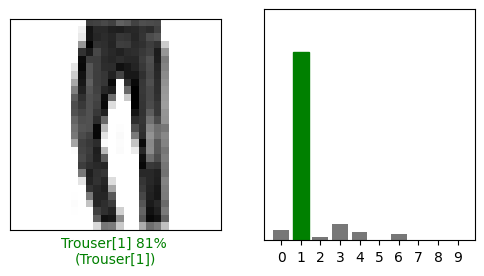


Prenda  6


<Figure size 640x480 with 0 Axes>

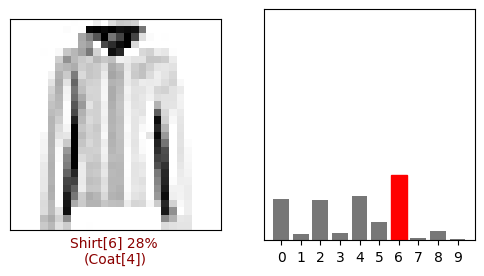


Prenda  7


<Figure size 640x480 with 0 Axes>

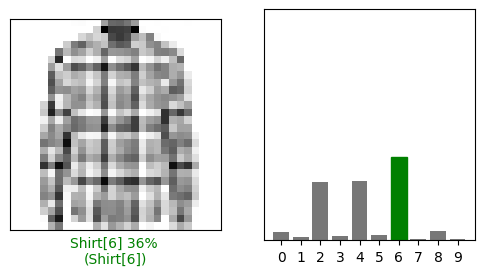


Prenda  8


<Figure size 640x480 with 0 Axes>

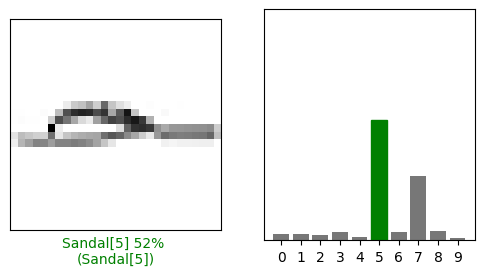


Prenda  9


<Figure size 640x480 with 0 Axes>

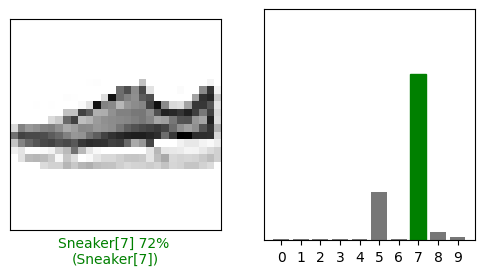

PREDICCIONES DEL MODELO  8

Características del caso:
 - Número de neuronas en la capa 1: 512
 - Función de activación: sigmoid
 - Optimizador: rmsprop

Prenda  0


<Figure size 640x480 with 0 Axes>

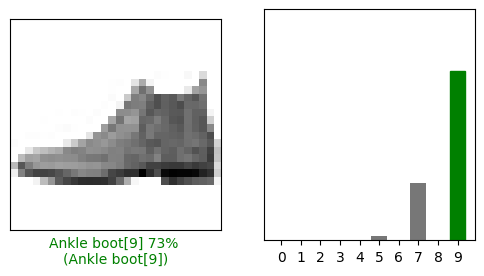


Prenda  1


<Figure size 640x480 with 0 Axes>

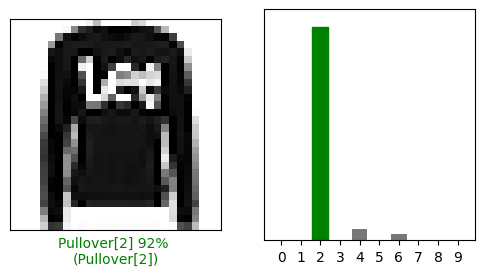


Prenda  2


<Figure size 640x480 with 0 Axes>

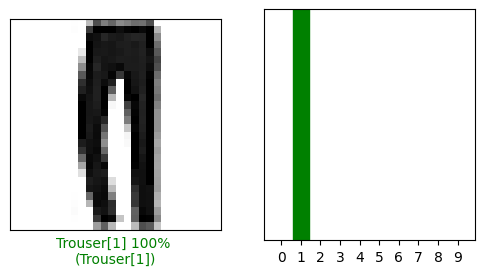


Prenda  3


<Figure size 640x480 with 0 Axes>

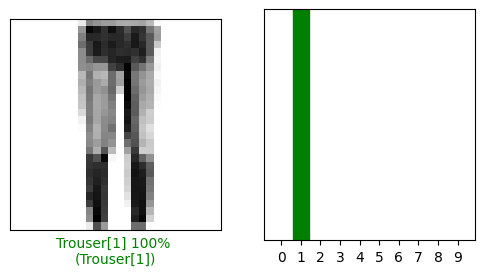


Prenda  4


<Figure size 640x480 with 0 Axes>

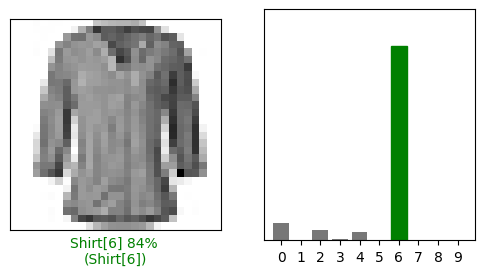


Prenda  5


<Figure size 640x480 with 0 Axes>

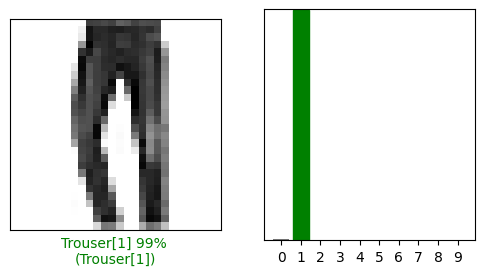


Prenda  6


<Figure size 640x480 with 0 Axes>

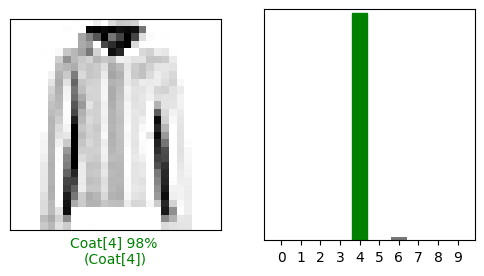


Prenda  7


<Figure size 640x480 with 0 Axes>

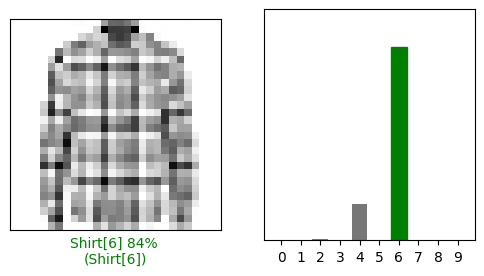


Prenda  8


<Figure size 640x480 with 0 Axes>

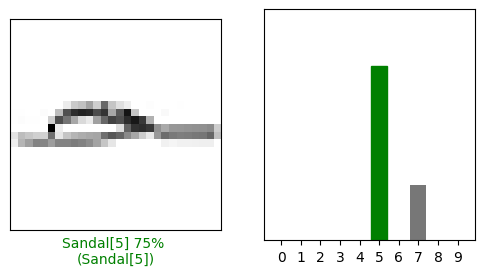


Prenda  9


<Figure size 640x480 with 0 Axes>

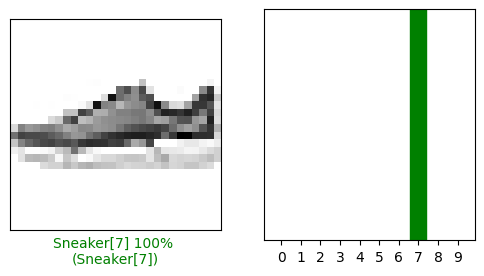

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(8):
  print("=======================================================================")
  print("PREDICCIONES DEL MODELO ", i + 1)
  print("=======================================================================")
  print("\nCaracterísticas del caso:")
  print(f" - Número de neuronas en la capa 1: {casos[i+1]['Neuronas_capa_1']}")
  print(f" - Función de activación: {casos[i+1]['Función de activación']}")
  print(f" - Optimizador: {casos[i+1]['Optimizador']}")

  for j in range(10):
    print("\nPrenda ", j)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(j, predicciones[i][j], test_labels, test_images.reshape(10000,28,28))
    plt.subplot(1,2,2)
    plot_value_array(j, predicciones[i][j],  test_labels)
    plt.show()
    plt.clf()

A la vista de todas estas gráficas, se llegan a unas conclusiones bastante parecidas a las obtenidas en los apartados 1 y 4. Estas son las siguientes:

- El optimizador 'sgd' suele dar peores precisiones. Y en cambio, los modelos con 'rmsprop' son modelos más precisos y con menos error. Esto se ve claro en estas gráficas ya que de cuatro modelos con 'sgd', tres tienen al menos un error de predicción en estas 10 imágenes. En cambio, ninguno de los modelos con 'rmsprop' tienen un error en estas 10 imágenes.

- Por otro lado, también destacar que, en general, los modelos con la función de activacion 'relu' funcionan mejor dando mejores resultados que los que implementan la función 'sigmoid'. Esto se ve reflejado en estas gráficas debido a que, al igual que con la comparación entre 'sgd' y 'rmsprop', los modelos con 'sigmoid' tienen significativamente más errores en estas 10 imágenes que los que tienen 'relu'.

- Por último, específicamente en estas gráficas se puede observar como todos los modelos en general tienen problemas con predecir sandalias (las predicen como sneakers), abrigos, sudaderas, camisas y camisetas (se suele confundir con las prendas de arriba). Y desde luego, una conclusión que se puede sacar es que los modelos son poco consistentes, porque es verdad que muchas predicciones de acierto son con al 100%, pero hay muchas otras que son al 50%, al 30%. Por esto, habría que tratar de mejorarlos con distintos hiperparámetros como se mencionó en el apartado 4.

# Apartado 7: Adam

En este apartado se debe mejorar el modelo usando el modelo del caso 3, pero cambiando el optimizador por ‘adam’ y la función de pérdida ‘sparse_categorical_crossentropy’. También se debe buscar en internet las bases de dicho optimizador y función de pérdida, y explicarlos con nuestras propias palabras planteando nuestras reflexiones respecto al resultado.

El optimizador **Adam** (Adaptive Moment Estimation) es un algoritmo popular en el aprendizaje profundo que ayuda a ajustar los parámetros de una red neuronal en tiempo real para mejorar su precisión y velocidad¹. Adam se adapta a la tasa de aprendizaje de cada parámetro basándose en sus gradientes históricos y el momento¹. Combina ideas de otros optimizadores, como el optimizador de momento, y calcula tasas de aprendizaje adaptativas individuales para diferentes parámetros a partir de estimaciones del primer y segundo momento de los gradientes¹³⁴.

Por otro lado, la función de pérdida **sparse_categorical_crossentropy** se utiliza en problemas de clasificación donde las clases son mutuamente excluyentes, es decir, cada muestra pertenece exactamente a una clase⁶. Esta función de pérdida trabaja con enteros que representan los índices de las clases, no con los valores reales⁶. Calcula la pérdida de entropía cruzada entre las etiquetas y las predicciones⁶.

Al cambiar el optimizador a Adam y la función de pérdida a sparse_categorical_crossentropy en el caso 3, podríamos esperar que el modelo se adapte mejor a los datos de entrenamiento y generalice mejor a los datos no vistos. Esto se debe a que Adam puede adaptar la tasa de aprendizaje para cada parámetro, lo que puede ser beneficioso si algunas características son más informativas que otras. Además, sparse_categorical_crossentropy es más eficiente en términos de memoria si tenemos muchas clases, ya que no necesita codificar las etiquetas en un formato one-hot.

Sin embargo, siempre es importante recordar que no existe un optimizador o una función de pérdida "mejor" en todos los casos. La elección del optimizador y la función de pérdida depende del problema específico que estemos tratando de resolver. Por lo tanto, siempre es una buena práctica probar diferentes optimizadores y funciones de pérdida para ver cuál funciona mejor para nuestro problema específico.

Origen: Conversación con Bing, 8/10/2023

(1) What is the Adam Optimizer and How is It Used in Machine Learning. https://www.aiplusinfo.com/blog/what-is-the-adam-optimizer-and-how-is-it-used-in-machine-learning/.

(2) Gentle Introduction to the Adam Optimization Algorithm for Deep .... https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/.

(3) Adam Explained | Papers With Code. https://paperswithcode.com/method/adam.

(4) What is the difference between sparse_categorical_crossentropy and .... https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c.

(5) . https://bing.com/search?q=Adam+optimizer+explanation.

(6) Adam optimizer: A Quick Introduction - AskPython. https://www.askpython.com/python/examples/adam-optimizer.

(7) . https://bing.com/search?q=sparse_categorical_crossentropy+loss+function+explanation.

(8) tf.keras.losses.SparseCategoricalCrossentropy | TensorFlow v2.14.0. https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy.

(9) What is the Mathematical formula for sparse categorical cross entropy loss?. https://stackoverflow.com/questions/73436424/what-is-the-mathematical-formula-for-sparse-categorical-cross-entropy-loss.

(10) What You Need to Know about Sparse Categorical Cross Entropy. https://rmoklesur.medium.com/what-you-need-to-know-about-sparse-categorical-cross-entropy-9f07497e3a6f.

(11) How Does TensorFlow SparseCategoricalCrossentropy Work. https://saturncloud.io/blog/how-does-tensorflow-sparsecategoricalcrossentropy-work/.

(12) undefined. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/.

(13) undefined. https://optimization.cbe.cornell.edu/index.php?title=Adam.

(14) undefined. https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other.

Explicación de los hiperparámetros de la función Adam de Keras:

- `learning_rate`: Es la tasa de aprendizaje, que determina cuánto se ajustan los parámetros del modelo en cada iteración del entrenamiento. Un valor más alto puede hacer que el entrenamiento sea más rápido, pero también puede causar oscilaciones y evitar que el modelo converja. El valor predeterminado es 0.001.

- `beta_1` y `beta_2`: Son los factores de decaimiento exponencial para las estimaciones del primer y segundo momento de los gradientes, respectivamente. Estos parámetros controlan la magnitud de los ajustes a los parámetros del modelo en cada iteración del entrenamiento.

- `epsilon`: Es un pequeño número que se añade para evitar la división por cero y mantener la estabilidad numérica.

- `amsgrad`: Es una variante del algoritmo Adam que utiliza una estimación del máximo de los segundos momentos de los gradientes para normalizar la tasa de aprendizaje.

- `name`: Es el nombre que se utilizará para las variables creadas por el optimizador.

- `weight_decay`: Si se establece, se aplica la decadencia del peso.

- `clipnorm` y `clipvalue`: Son valores que, si se establecen, recortan el gradiente de cada peso para que su norma o valor no sea mayor que estos valores, respectivamente.

- `global_clipnorm`: Si se establece, recorta el gradiente de todos los pesos para que su norma global no sea mayor que este valor.

- `use_ema`, `ema_momentum` y `ema_overwrite_frequency`: Estos parámetros están relacionados con el uso de una media móvil exponencial (EMA) de los pesos del modelo.

- `jit_compile`: Si es True, el optimizador utilizará la compilación XLA.

- `mesh`: Cuando se proporciona, el optimizador se ejecutará en modo DTensor.

- `**kwargs`: Argumentos de palabras clave solo utilizados para compatibilidad con versiones anteriores.

In [ ]:
# DATOS DEL CASO
n_neuronas = casos[3]['Neuronas_capa_1']
f_activacion = casos[3]['Función de activación']
optimizador = 'adam'  # Cambiado a 'adam'
funcion_perdida = 'sparse_categorical_crossentropy'  # Cambiado a 'sparse_categorical_crossentropy'

# CARACTERISTICAS DEL CASO
print("\n Características del caso:")
print(f" - Número de neuronas en la capa 1: {n_neuronas}")
print(f" - Función de activación: {f_activacion}")
print(f" - Optimizador: {optimizador}")

# MODELO:
network = models.Sequential()
network.add(Flatten(input_shape = (28, 28)))
network.add(layers.Dense(n_neuronas, activation=f_activacion, input_shape=(28*28,)))
network.add(layers.Dense(10, activation='softmax'))

print("\nSUMMARY")
network.summary()

network.compile(optimizer=optimizador, loss=funcion_perdida, metrics=['accuracy'])

print("\nENTRENAMIENTO:")
network.fit(train_images, train_labels, epochs=5, batch_size=128)

print("\nVALIDACIÓN:")
test_loss, test_acc = network.evaluate(test_images, test_labels)

print('\ntest_loss:', test_loss)
print('test_acc:', test_acc)


 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: adam

SUMMARY
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_50 (Dense)            (None, 10)                7850      
                                                                 
 dense_51 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________

ENTRENAMIENTO:
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 1.4851 - accuracy: 0.6110
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - lo

Se observa que la precisión es mayor que incluso el mejor caso estudiado hasta ahora, a continuación mostramos la matriz de confusión para este caso en concreto:

CASO ADAM

 Características del caso:
 - Número de neuronas en la capa 1: 10
 - Función de activación: sigmoid
 - Optimizador: adam
 - Funcion de perdida: sparse_categorical_crossentropy
313/313 [==============================] - 1s 2ms/step

 PINTAMOS LA MATRIZ DE CONFUSION:



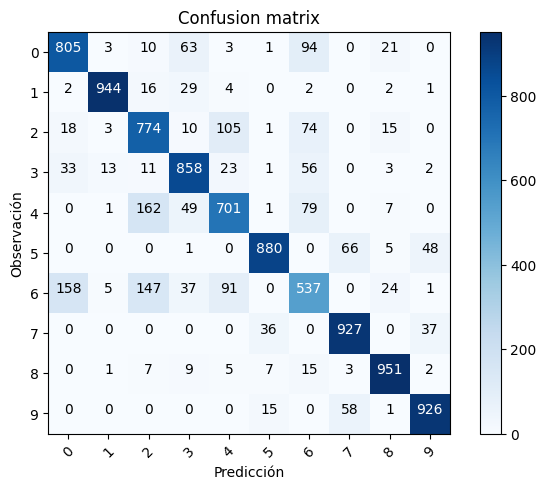

<Figure size 640x480 with 0 Axes>

In [ ]:
print("=======================================================================")
print("CASO ADAM")
print("=======================================================================")

# DATOS DEL CASO
print("\n Características del caso:")
print(f" - Número de neuronas en la capa 1: {n_neuronas}")
print(f" - Función de activación: {f_activacion}")
print(f" - Optimizador: {optimizador}")
print(f" - Funcion de perdida: {funcion_perdida}")

# Predicción de valores desde el dataset de validación
Y_pred = network.predict(test_images)

# Convertir en predicciones de clases desde los vectores one-hot encoding
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = test_labels  # Aquí se ha cambiado 'np.argmax(test_labels)' por 'test_labels'

# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Dibujar la matriz de confusión
print("\n PINTAMOS LA MATRIZ DE CONFUSION:\n")
plot_confusion_matrix(confusion_mtx, classes = range(10))

Se observa como ADAM supone una mejora con respecto a los otros métodos

Como clarificación de las variables mencionadas anteriormente, se relacionan de la siguiente forma en ADAM (Adaptive Moment Estimation):

\begin{equation}
m = \beta_1 \cdot m + (1 - \beta_1) \cdot \Delta W
\end{equation}

\begin{equation}
v = \beta_2 \cdot v + (1 - \beta_2) \cdot \Delta W^2
\end{equation}

\begin{equation}
W = W - \frac{\alpha \cdot m}{\sqrt{v + \epsilon}}
\end{equation}

m y v representan los dos momentos, siendo m el que modela la media de los gradientes a lo largo del tiempo, mientras que v hace lo mismo con la varianza. β1 es igual, en la mayoría de los casos, a 0.9, mientras que β2 casi siempre se fija en 0.99.

https://datasmarts.net/es/que-es-un-optimizador-y-para-que-se-usa-en-deep-learning/#

1. PORQUE CON ADAM SE UTILZA sparse_categorical_crossentropy

La función de pérdida `sparse_categorical_crossentropy` se utiliza en problemas de clasificación donde las clases son mutuamente excluyentes, es decir, cada muestra pertenece exactamente a una clase⁶. Esta función de pérdida trabaja con enteros que representan los índices de las clases, no con los valores reales⁶. Calcula la pérdida de entropía cruzada entre las etiquetas y las predicciones⁶. Se utiliza con el optimizador Adam porque Adam es un algoritmo eficiente para optimizar esta función de pérdida. Adam se adapta a la tasa de aprendizaje de cada parámetro basándose en sus gradientes históricos y el momento¹.

2. PORQUE sparse_categorical_crossentropy PROVOCABA UN ERROR EN EL CODIGO INICIAL (YA ESTA CORREGIDO EL ERROR)

El error en tu código se debe a que estás intentando aplicar `np.argmax` en el eje 1 (`axis=1`) de `test_labels`, pero `test_labels` es un array de una dimensión. Esto sucede porque cuando usaste la función de pérdida `sparse_categorical_crossentropy`, no necesitaste convertir las etiquetas a representaciones one-hot, por lo que `test_labels` sigue siendo un array de una dimensión⁶. Por lo tanto, cuando intentas usar `np.argmax(test_labels, axis = 1)`, Python no puede encontrar el eje 1 y lanza un error⁷.

Origen: Conversación con Bing, 8/10/2023

(1) Why do my target labels need to begin at 0 for sparse categorical cross .... https://datascience.stackexchange.com/questions/90643/why-do-my-target-labels-need-to-begin-at-0-for-sparse-categorical-cross-entropy.

(2) Keras Loss Functions: Everything You Need to Know - neptune.ai. https://neptune.ai/blog/keras-loss-functions.

(3) . https://bing.com/search?q=why+sparse_categorical_crossentropy+causes+error+in+code.

(4) . https://bing.com/search?q=why+use+sparse_categorical_crossentropy+with+Adam+optimizer.

(5) Why binary_crossentropy and categorical_crossentropy give different .... https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances.

(6) python - difference between tf.keras.losses ... - Stack Overflow. https://stackoverflow.com/questions/62110793/difference-between-tf-keras-losses-sparsecategoricalcrossentropy-vs-sparse-ca.

(7) neural network - Sparse_categorical_crossentropy vs categorical .... https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy.

(8) Error in keras sparse_categorical_crossentropy loss function. https://stackoverflow.com/questions/61726869/error-in-keras-sparse-categorical-crossentropy-loss-function.

(9) Error while using categorical_crossentropy - Stack Overflow. https://stackoverflow.com/questions/63211181/error-while-using-categorical-crossentropy.

(10) undefined. https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other.

(11) undefined. https://stackoverflow.com/questions/45094625/error-when-checking-target-sparse-categorical-crossentropy-output-shape.

(12) undefined. https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy.

# REFLEXIÓN



Comenzamos la práctica basándonos en el código de ejemplo propuesto como temario de clase en el archivo 2_1_Un_primer_vistazo_a_una_Red_Neuronal, teniendo este código junto con la explicación fuimos haciendole las modificaciones necesarias para cumplir los requisitos de la práctica.


En un principio tratamos de dividirnos el trabajo, cada uno haciendo diferentes apartados. Sin embargo, nos dimos cuenta rápidamente que en un trabajo de este tipo este método provoca más dificultades que beneficios, por lo que nos juntamos fisicamente y, una vez hecho el bucle de entrenamiento de los modelos nos organizamos basándonos en ese modelo para seguir programando cada uno por su cuenta.


Nos enfrentamos a un desafío importante: la plataforma de Google Colab no actualiza en tiempo real los cambios. Esto resultó en retrasos en nuestro trabajo, ya que a menudo sobrescribíamos el trabajo de los demás. Para abordar este problema, implementamos un método de trabajo en el que cada uno de nosotros creó su propio archivo individual para trabajar en fragmentos de la práctica. Sin embargo, este enfoque tuvo un inconveniente: a veces se producían conflictos con variables en diferentes secciones, y se llamaban a los datos y a las librerias varias veces. Para solucionar esto, creamos un archivo llamado "memoria" en el que manteníamos coherencia en nuestro código y documentábamos las diferentes partes.


Muchas veces construimos código sobre el trabajo de otro compañero por lo que se puede afirmar que todos los integrantes del equipo entienden la práctica en su conjunto, y que todos han aportado algo en todos los apartados de la práctica.